<a href="https://colab.research.google.com/github/parkmy99/credit_union_project/blob/main/Credit_Union_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Credit Union: Using Time Series to Predict Member Engagement**


##Work Breakdown
**Kaysi Koslov**
<br>
>  Team communicator, facilitated communication between team and sponsor, notebook organization and cleanup, interpreted ARIMA model results and data visualization results
<br>

**Parker Myers**
<br>
>  Project Manager, set weekly goals and delegated team responsibilities, data cleanup and import through SQL and Python, created data visualizations, primary coder
<br>

**Weizhe Sun**
<br>
>  Mathematical ARMA model buildup, researched methods for data transformations, implemented data seasonality, secondary coder
<br>

##Abstract
This project can be considered a continuation and expansion of the [previous project](https://colab.research.google.com/drive/1ad-Px26G0pS7Za0w7R9uHjIStu40irg4?usp=drive_link) from Fall 2022 working with a local credit union.  We utilized two different methods of scaling data, standardizing which transforms the data, and normalizing which scaled the data, to create an account health score which measures how much a member engages with their account.  We used an autoregressive integrated moving average (ARIMA) model to track how this account health score changes over time.  Two sets of optimal ARIMA orders were found based on different approaches.  


## Introduction

The purpose of this project is to expand on the previous Math Clinic's work with a local credit union. The previous project focused on developing a member engagement score which could be used to predict member churn.

Similar to the previous project, our project aims to create an 'account health' score for credit union members, which will be calculated using various account activity metrics. The account health score will be used to build a time series model that will allow the sponsor to predict whether or not a member's account will become 'at risk'. By understanding this, marketing efforts by the credit union can be deployed to help improve engagement of 'at risk' member accounts, which will benefit the credit union overall.  

Key steps and goals of this project include:
- **Criteria selection:** Determination of what variables are indicators of account health
- **Data collection:** Partnering with the sponsor to collect appropriate data needed
- **Account Health score development:** Creating the account health score based on criteria and identification of potential trends discovered in collection phase
- **Time series implementation:** Utilizing time series model methods to predict when a member's account is 'at risk'
- **Accuracy determination:** Determining appropriate methods to ensure time series models are accurate

##Data Import and Wrangling

###Notebook Environment Setup and Snowflake Connector Installation

> As a note for any future work with this project, the error at end of sqlalchemy upgrade can be ignored. It has no impact on pulling data. This is a known issue with Snowflake and is being worked on.

> Additionally, the SnowFlake login credentials were provided by the Credit Union.

In [ ]:
pip install --upgrade snowflake-sqlalchemy

In [ ]:
pip install snowflake-connector-python

In [ ]:
pip install "snowflake-connector-python[pandas]"

In [ ]:
pip install pmdarima

In [ ]:
pip install ipywidgets

###Python Package Import

In [ ]:
## Code to load necessary Python packages, note: make sure to run the snowflake connector code before running this cell for all packages
%matplotlib inline
import math
import statistics
from google.colab import files
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import snowflake.connector
import scipy.stats as stats
import statsmodels.formula.api as smf
import joblib
from sklearn.utils import math
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from yellowbrick.regressor import ResidualsPlot
from IPython.display import display, clear_output
import ipywidgets as widgets
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import pylab as py
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import warnings
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import gc
import warnings
warnings.filterwarnings('ignore')

###Importing Tables From Snowflake


The credit union stores their data in a Snowflake database. To access the data from the credit union's Snowflake, the Snowflake connector is installed, which allows us to use an SQL query to pull the data into a Pandas dataframe.

The original dataset available to us consisted of various tables housed in Snowflake (the sponsor's SQL database environment). We were originally given 5 tables which totalled nearly 2 GB with around 40 total columns. Some of the columns were duplicates (such as month_begin_date and member_identifier) or irrelevant to our analysis, so they were removed prior to pulling the data into Python.

Since we did not have access to the sponsor's full suite of resources in Snowflake, the data was aggregated for us (our permissions would not allow us to use the resources it would take to calculate standard deviation, averages, etc. for the amount of data we were given). Cleaning up the data consisted of narrowing down the time frame to only 4 years of data, aggregating the data into monthly intervals, and filtering out members who did not have their account open for each month in the 4 year period (48 months total).  Although we would have liked to aggregate our data on a biweekly basis, we opted for monthly intervals at the reccomendation of the credit union due to computational constraints.  

This 4 year period was determined dur to constraints posed by the lack of digital transaction related variables.  These variables did not extend beyond the past 4 years.   


After cleaning and further data reduction within Snowflake, the final dataset pulled into this notebook contains data between January 2020 to December 2023 and 1.9 million rows.

In [ ]:
conn = snowflake.connector.connect(
    user='',
    password='',
    account='',
    warehouse='CU_XS',
    database='CU_DENVER',
    schema='CU_DENVER',
    role = 'CU_DENVER',
    insecure_mode=True
)
main_tbl = pd.read_sql("SELECT * FROM CU_DENVER.SPRING_2024.MAIN_PROJ_TABLE", conn)

This code cell can take over a minute to run and may produce a warning error concerning Pandas and SQL.  This warning can be ignored.  

###Data Cleaning and Preparation

###Variable Description

For visualizations and modeling, we reduced the avilable data down to a table with 24 columns as described below.


---


Variable      |  Data Type    | Description | Source | Quantitative/Categorical
------------- | ------------- | ----------- | ------ | --------------
MEMBER_IDENTIFIER  | Object  | Unique ID for each member | Sponsor | Categorical
MONTH_BEGIN_DATE  | Object | First day of the month and year (yyyy-mm-01) | Sponsor | Categorical
IN_BRANCH_AVG  | Float64 | Proportion of a member's transactions which took place in branch for the month| Student |Quantitative
TRANSFER_AVG  | Float64  | Proportion of a member's transactions that are transfers for the month| Student | Quantitative
COUNT_TX  | Int16  | Member's number of transactions for the month | Sponsor | Quantitative
MAX_TX  | Float64  | Member's maximum transaction amount for the month (USD)  | Sponsor | Quantitative
MIN_TX  | Float64 | Member's smallest transaction for the month (USD)| Sponsor | Quantitative
MEDIAN_TX  | Float64 | Member's median transaction amount for the month (USD) | Student | Quantitative
AVG_TX_AMT | Float64 | Member's average transaction amount for the month (USD)| Student | Quantitative
SD_TX_AMT  | Float64  | Standard deviation for member's transaction amount for the month (USD)| Student | Quantitative
BALANCE_AVG | Float64  | Member's average account balance for the month (USD)| Student| Quantitative
SD_BALANCE  | Float64  |  Standard deviation of account balance for the month (USD)| Student | Quantitative
MAX_BALANCE  | Float64  | Member's maximum account balance for the month (USD)| Student | Quantitative
MIN_BALANCE   | Float64 |  Member's minimum account balance for the month (USD) | Student | Quantitative
AVG_BALANCE_CHANGE  | Float64  |  Member's avearge account balance change for the month (USD)| Student | Quantitative
CARD_AVG  | Float64  |  Member's average transaction amount on credit/debit card for the month (USD) | Student | Quantitative
COUNT_WITHDRAWAL  | Int16  | Number of withdrawals member made in the month | Sponsor | Quantitative
COUNT_DEPOSIT  | Int16  | Member's total deposit amount for the month (USD)| Sponsor | Quantitative
LOGIN_COUNT  | Int16 | Number of times member logged in to online banking for the month| Sponsor | Quantitative
TRANSFER_COUNT  | Int16 | Member's number of transfer transactions for the month | Sponsor | Quantitative
ALL_OTHER_TYPE_COUNT | Int16  | Count of all other credit union services for the month | Sponsor | Quantitative
FAILURE_COUNT  | Int16  | Count of all failed digital-related actions for the month | Sponsor | Quantitative
SUCCESS_COUNT  | Int16  | Count of all Successful digital-related actions for the month | Sponsor | Quantitative


####General Clean Up and Formatting

First, we had to assign variable types to each column of the `main_tbl` dataframe. Although the majority of data wrangling occured through SnowFlake, `MONTH_BEGIN_DATE` had to be adjusted in Python.

One issue faced was when trying to create visualizations where we found that the data would not be in chronological order. To address this issue, we realized the importance of sorting the `MONTH_BEGIN_DATE` column before converting it to an easily interpretable string format. We accomplished this by first using the `.to_datetime()` function to parse the dates correctly according to the specified format (yyyy-mm-dd), and then utilizing the `.strftime()` function to adjust the format of the dates to our desired month - year string format for easy interpretaiton in exploratory analysis.

In [ ]:
# Assign variable types to each column
main_tbl1 = main_tbl.astype({'MEMBER_IDENTIFIER':'string','MONTH_BEGIN_DATE':'string', 'IN_BRANCH_AVG':'float32', 'TRANSFER_AVG':'float32',
                            'COUNT_TX':'int', 'MAX_TX':'float32', 'MIN_TX':'float32', 'MEDIAN_TX':'float32', 'AVG_TX_AMT':'float32',
                            'SD_TX_AMT':'float32', 'BALANCE_AVG':'float32', 'SD_BALANCE':'float32', 'MAX_BALANCE':'float32',
                            'MIN_BALANCE':'float32', 'AVG_BALANCE_CHANGE':'float32', 'CARD_AVG':'float32', 'COUNT_WITHDRAWAL':'int',
                            'COUNT_DEPOSIT':'int', 'LOGIN_COUNT':'int', 'TRANSFER_COUNT':'int', 'ALL_OTHER_TYPE_COUNT':'int',
                            'FAILURE_COUNT':'int', 'SUCCESS_COUNT':'int', 'AGE_CLASS':'string', 'MEDIAN_HH_INCOME':'float32'})

# Sort table by 'MONTH_BEGIN_DATE' for later
main_tbl1 = main_tbl1.sort_values(by='MONTH_BEGIN_DATE')

# Change 'MONTH_BEGIN_DATE' to date format
main_tbl1['MONTH_BEGIN_DATE'] = pd.to_datetime(main_tbl1['MONTH_BEGIN_DATE'], format='%Y-%m-%d')

# Adjust format of 'MONTH_BEGIN_DATE' to make it more readable
main_tbl1['MONTH_BEGIN_DATE'] = main_tbl1['MONTH_BEGIN_DATE'].dt.strftime('%b %Y')

# Convert column names to lowercase for ease of use later
main_tbl1.columns = main_tbl1.columns.str.lower()

# change name of last 6 column names to make sure they indicate digital variables
main_tbl1 = main_tbl1.rename(columns={
    'login_count': 'digital_login_count',
    'transfer_count': 'digital_transfer_count',
    'all_other_type_count': 'other_digital_tx_count',
    'failure_count': 'digital_failed_tx_count',
    'success_count': 'digital_success_tx_count'
})

####Filtering

In order to accurately implement our time series model and to ensure we only analyzed active members during the entire 48 month period, we subsetted our data further by only pulling members who had 48 unique data entries - representing an entry for each `month_begin_date`. While we could have used various statistical or ML techniques to fill in the null values, we decided to use the aforementioned method instead so that we could prioritize model building under the time contraints.

In addition to filtering out members with less than 48 data entries, we also changed all 'NaN' values for `card_avg` to 0, as advised by the sponsor. A null value for `card_avg` was explained by the sponsor to represent no card activity for a member in a given `month_begin_date`, which is why changing the value to 0 is appropriate.

The final `main_filter_tbl` contains 29,646 member with 48 entries per member, making the final row count for `main_filter_tbl` 1,423,008.  This subset contains 74.17% of the original data imported from Snowflake.

In [ ]:
###REMOVE MEMBERS WHO DO NOT HAVE EXACTLY 48 ENTRIES, 1 FOR EACH MONTH
# Group by 'member_identifier' and count unique 'year_month' for each member
counts = main_tbl1.groupby('member_identifier')['month_begin_date'].nunique()

# Filter for members who have 48 unique months
members_with_48_months = counts[counts == 48].index
main_filter_tbl = main_tbl1[main_tbl1['member_identifier'].isin(members_with_48_months)]

###CHANGE NULL CARD_AVG VALUES TO 0
main_filter_tbl['card_avg'] = main_filter_tbl['card_avg'].fillna(0)

###SEGMENT MEMBERS BY MEDIAN_HH_INCOME_CLASS
bins = [0, 50000, 100000, float('inf')]
labels = ['Less than $50k', '$50k-$100k', 'Over $100k']
main_filter_tbl.loc[:, 'median_hh_income_class'] = pd.cut(main_filter_tbl['median_hh_income'], bins=bins, labels=labels)

###Initial test_df and Age_class Segmentation

In [ ]:
#subset relevant columns for testing and model creation
test_df = main_filter_tbl[['member_identifier', 'month_begin_date',
                           'in_branch_avg', 'transfer_avg', 'avg_tx_amt',
                           'balance_avg', 'avg_balance_change', 'card_avg', 'count_withdrawal',
                           'count_deposit', 'digital_login_count', 'digital_transfer_count',
                           'other_digital_tx_count', 'digital_failed_tx_count',
                           'digital_success_tx_count', 'age_class', 'median_hh_income_class']]
print(test_df.columns)

#Delete unused variables
del main_tbl1, counts, members_with_48_months, main_filter_tbl
#will not delete main_tbl in case it is needed later so we can avoid importing from snowflake again

Index(['member_identifier', 'month_begin_date', 'in_branch_avg',
       'transfer_avg', 'avg_tx_amt', 'balance_avg', 'avg_balance_change',
       'card_avg', 'count_withdrawal', 'count_deposit', 'digital_login_count',
       'digital_transfer_count', 'other_digital_tx_count',
       'digital_failed_tx_count', 'digital_success_tx_count', 'age_class',
       'median_hh_income_class'],
      dtype='object')


In [ ]:
def custom_age_sort_key(age_class):
    # Map each age class to a unique numerical value representing its order
    order_map = {
        'Under 25': 0,
        '25-34': 1,
        '35-44': 2,
        '45-54': 3,
        '55-64': 4,
        'Over 65': 5
    }
    return order_map.get(age_class, -1)  # Return -1 for any unexpected age_class

# Create a sorted list of unique age classes
sorted_age_classes = sorted(test_df['age_class'].unique(), key=custom_age_sort_key)

# Create a dictionary directly sorted by the age classes
sorted_age_dfs = {age_class: test_df[test_df['age_class'] == age_class] for age_class in sorted_age_classes}

print("Row Count for Each Age Class\n")
# Iterate over the items in the sorted dictionary
for age_class, df in sorted_age_dfs.items():
    # Print the count of rows for each DataFrame
    print(f"{age_class}:  {len(df)} rows\n")

del sorted_age_classes

Row Count for Each Age Class

Under 25:  70032 rows

25-34:  277152 rows

35-44:  294720 rows

45-54:  240192 rows

55-64:  221520 rows

Over 65:  314736 rows



We decided to further subset the data based on members' age ranges.  These age ranges are under 25 years old, 25-34 years old, 35-44 yeras old, 45-54 years old, 55-64 years old, and over 65 years old.

The different demographics were shown to have relatively different trends, so using one model on the entire data set would not provide accurate results. Subsetting the data allowed us to tailor each model to a specific group rather than the entire data set   

By creating a dictionary of the subsetted data, we can more easily access each age_class via iterations and do not need to filter each time we wanted to perform an operation on an age_class.    

###Outlier Removal

For each variable in `test_df` and `sorted_age_dfs`, outliers were removed. Outliers were considered to be column values 3.5 standard deviations away from the column mean.

The function below was created to remove outliers and print out the means, cutoff values, and number of rows removed for each variable it was applied to.

In [ ]:
def remove_outliers(df, columns):
    """
    Outlier Removal function. Removes outliers from specified data frame
    that are not within 3.5 standard deviations from the mean of indicated columns.
    Prints out variable name, and corresponding mean, cutoff thereshold, rows
    removed per column, and total rows removed from data frame.

    df: specified data frame to apply function
    columns: columns in df to have outliers removed from.
    """
    initial_row_count = len(df)
    rows_removed_stats = {}
    new_total_count=0
    # Iterate over each column specified for outlier removal
    for column in columns:
        column_initial_count = len(df[column])  # Store the row count before processing this column

        # Calculate the mean and standard deviation of the column
        mean = df[column].mean()
        std = df[column].std()

        # Determine the cutoff values for being considered an outlier (3.5 standard deviations from the mean)
        cutoff_high = mean + 3.5 * std

        if (df[column] < 0).any():
            cutoff_low = mean - 3.5 * std
            df = df[(df[column] >= cutoff_low) & (df[column] <= cutoff_high)]
        else:
            cutoff_low = 0
            df = df[(df[column] <= cutoff_high)]

        # Calculate how many rows were removed in this iteration
        rows_removed = column_initial_count - len(df)
        percent_removed = (rows_removed / column_initial_count) * 100  # Calculate percentage of rows removed
        new_total_count += rows_removed
        # Store the results for each column
        rows_removed_stats[column] = (column, mean, cutoff_low, cutoff_high, rows_removed, percent_removed)

    for column, stats in rows_removed_stats.items():
        print(f"{stats[0]:<30} {stats[1]:<12.2f} {stats[2]:<15.2f} {stats[3]:<15.2f} {stats[4]:<4} ({stats[5]:.3f}%)")

    print('\n')
    print(f"Total Rows Removed: {new_total_count:<3} ({(new_total_count/initial_row_count)*100:.3f}%)")
    print('-' * 100)
    return df

####For whole set test_df

In [ ]:
print('Variable means and cutoffs for whole dataset\n')
print(f"{'Variable':<30} {'Mean':<12} {'Cutoff (Low)':<15} {'Cutoff (High)':<15} {'Rows Removed Per Column':<15}")
print('-' * 100)  # Print a line for separation

test_df_filtered = remove_outliers(test_df, test_df.iloc[:,2:15]) #.iloc indicates integer loction of columns rather than column names
del test_df

Variable means and cutoffs for whole dataset

Variable                       Mean         Cutoff (Low)    Cutoff (High)   Rows Removed Per Column
----------------------------------------------------------------------------------------------------
in_branch_avg                  0.02         0.00            0.18            22347 (1.576%)
transfer_avg                   0.19         0.00            0.80            4504 (0.323%)
avg_tx_amt                     426.16       0.00            5404.30         5528 (0.397%)
balance_avg                    4852.04      -40506.71       50210.79        14865 (1.073%)
avg_balance_change             3.08         -635.77         641.93          17296 (1.261%)
card_avg                       45.50        0.00            416.89          8660 (0.640%)
count_withdrawal               53.00        0.00            200.98          8522 (0.634%)
count_deposit                  11.74        0.00            48.72           15108 (1.130%)
digital_login_count          

####Per Age_class

In [ ]:
filtered_age_class_dfs = {}
# Print table headers for means and cutoffs
print('Variable means and cutoffs for each age class\n')
for age_class, df in sorted_age_dfs.items():
    print('\n')
    print(f"Age class: {age_class:<10}")
    print('-' * 100)
    print(f"{'Variable':<30} {'Mean':<12} {'Cutoff (Low)':<15} {'Cutoff (High)':<15} {'Rows Removed Per Column':<15}")
    print('-' * 100)  # Print a line for separation
    filtered_df = remove_outliers(df, df.iloc[:,2:15])
    filtered_age_class_dfs[age_class] = filtered_df

del sorted_age_dfs

Variable means and cutoffs for each age class



Age class: Under 25  
----------------------------------------------------------------------------------------------------
Variable                       Mean         Cutoff (Low)    Cutoff (High)   Rows Removed Per Column
----------------------------------------------------------------------------------------------------
in_branch_avg                  0.01         0.00            0.11            910  (1.299%)
transfer_avg                   0.21         0.00            0.80            225  (0.326%)
avg_tx_amt                     122.24       0.00            814.02          667  (0.968%)
balance_avg                    1096.08      -8380.35        10572.51        528  (0.774%)
avg_balance_change             1.82         -128.48         132.13          1005 (1.484%)
card_avg                       35.22        0.00            189.29          632  (0.948%)
count_withdrawal               50.04        0.00            158.79          335  (0.507

##Exploratory Analysis

The function `hist_plotter` was created  to streamline the process of creating histograms for data visualization.

In [ ]:
def hist_plotter(dictionary:dict, variable:str, category_name:str, log: bool=False):
    """
    Creates histograms for each key value in dictionary

    dictionary: Dictionary name
    variable (str): String column name of variable to plot
    category_name (str): Name of overall category/class of keys (i.e., age classes, book titles, etc.)
    num_bins (int): number of bins to parse histogram into
    log (default=False): True if histogram should use log scale
    """
    num_bins=40
    fig, axes = plt.subplots(nrows=math.ceil(len(dictionary)/3), ncols=3, figsize=(12, 6))
    fig.suptitle(f"{variable} distrubution by {category_name}", fontsize=16) #update key name if necessary
    for i, key in enumerate(dictionary):
        ax = axes[i // 3, i % 3]
        df = dictionary[key]

        max_val = df[variable].max()
        min_val = df[variable].min()
        bin_width = (max_val - min_val) / num_bins
        bins = np.arange(min_val, max_val + bin_width, bin_width)

        if log is False:
            # Calculate and plot mean
            mean_val = df[variable].mean()
            ax.axvline(mean_val, color='blue', linewidth=1, label='Mean')

            # Calculate and plot quartiles
            lower_quartile = df[variable].quantile(0.25)
            upper_quartile = df[variable].quantile(0.75)
            ax.axvline(lower_quartile, color='#AE9C45', linestyle='dashed', linewidth=1, label='Lower Quartile')
            ax.axvline(upper_quartile, color='#052955', linestyle='dashed', linewidth=1, label='Upper Quartile')

        ax.hist(df[variable], bins=bins, log=log, color= 'silver', edgecolor='dimgray')
        ax.set_xlim(min_val, max_val)
        ax.set_title(key)
    if log is False:
        # Creating proxy artists for the global legend
        proxy_mean = plt.Line2D([], [], color='blue', linewidth=1, label='Mean')
        proxy_lower_quartile = plt.Line2D([], [], color='#AE9C45', linestyle='dashed', linewidth=1, label='Lower Quartile')
        proxy_upper_quartile = plt.Line2D([], [], color='#052955', linestyle='dashed', linewidth=1, label='Upper Quartile')
        # Add one global legend
        fig.legend(handles=[proxy_lower_quartile, proxy_mean, proxy_upper_quartile],
                  loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=3)

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

###Age Class Distributions

For each age class, the total number of members are as follows:

| Age Class                   | Number of Members |
|-----------------------------|----------------------------|
| Under 25                    | 1242                    |
| 25 - 34                     | 4908                   |
| 35 - 44                     | 5276                  |
| 45 - 54                     | 4313                   |
| 55 - 64                     | 4037                   |
| Over 65                     | 5688                 |


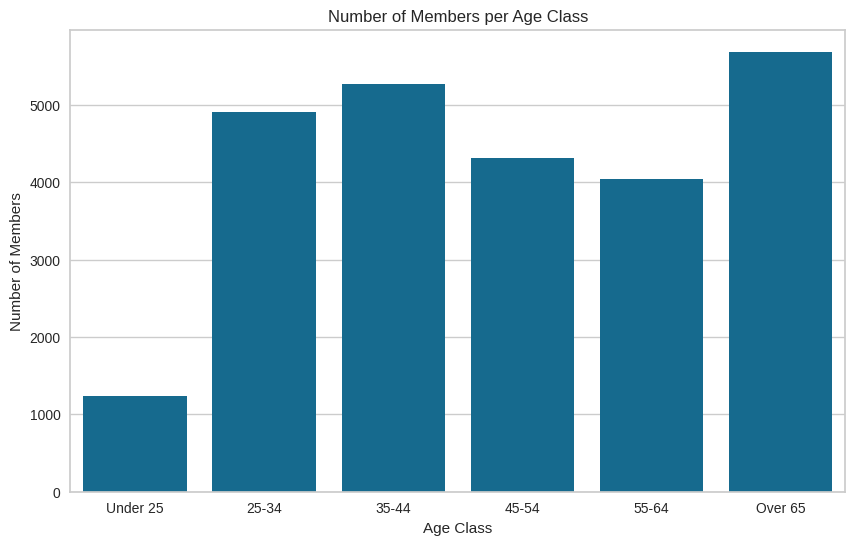

In [ ]:
data = []
# Loop through each DataFrame in the dictionary and collect the age class and the number of Members
for age_class, df in filtered_age_class_dfs.items():
    data.append({'Age Class': age_class, 'Member Count': len(df)/48})

plot_data = pd.DataFrame(data)
plt.figure(figsize=(10, 6))  # You can adjust the size as per your preference
sns.barplot(data=plot_data, x='Age Class', y='Member Count')
plt.title('Number of Members per Age Class')
plt.ylabel('Number of Members')
plt.xlabel('Age Class')
plt.xticks()
plt.show()

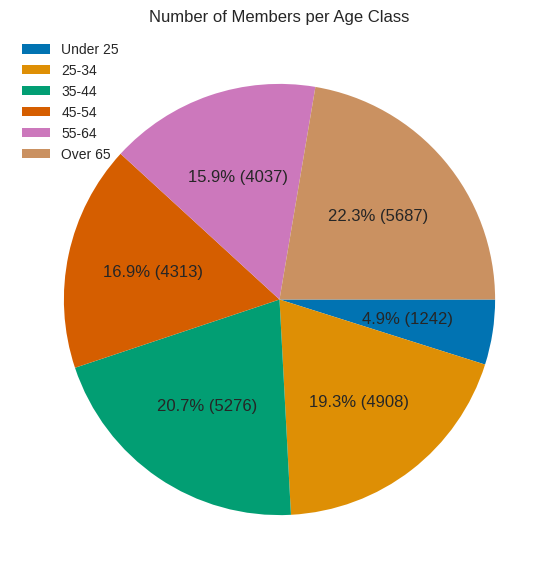

In [ ]:
# Plots the number of members per age class in a pie chart
labels = plot_data['Age Class']
sizes = plot_data['Member Count']
counts = plot_data['Member Count']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels = None, autopct=lambda pct: f'{pct:.1f}% ({int(pct / 100 * sum(sizes))})', counterclock= False,
        colors = sns.color_palette("colorblind"))
plt.title('Number of Members per Age Class')
plt.legend(labels, loc = 2)
plt.show()

###In_branch_avg Histogram

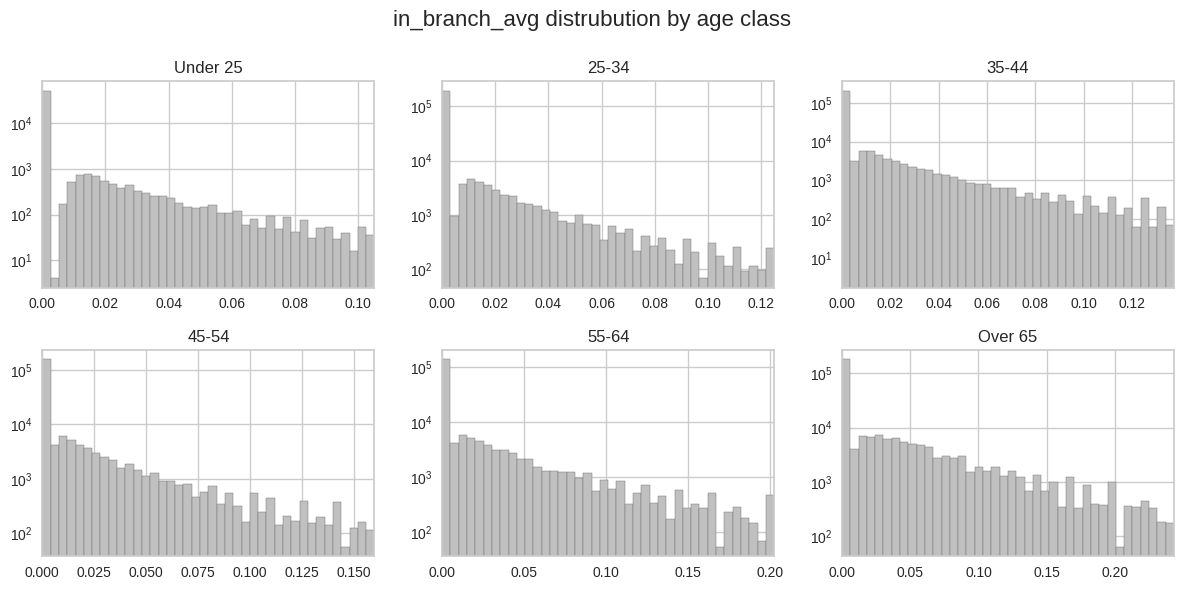

In [ ]:
hist_plotter(filtered_age_class_dfs, 'in_branch_avg', 'age class', True)

Between the different age classes, there are not many differences in the data.  In all 6 age classes, the data skews heavily to the right.  Interestingly, Under 25, 25-34, 35-44, and 45-54 all have values that range from 0.0 to 0.6 while 55-64 and Over 65 have values that range from 0 to 0.8 and 0 to 0.10.  This histogram shows that while many members do have large average transactions in branch, the total number of members that do is still higher.  

###Transfer_avg Histogram

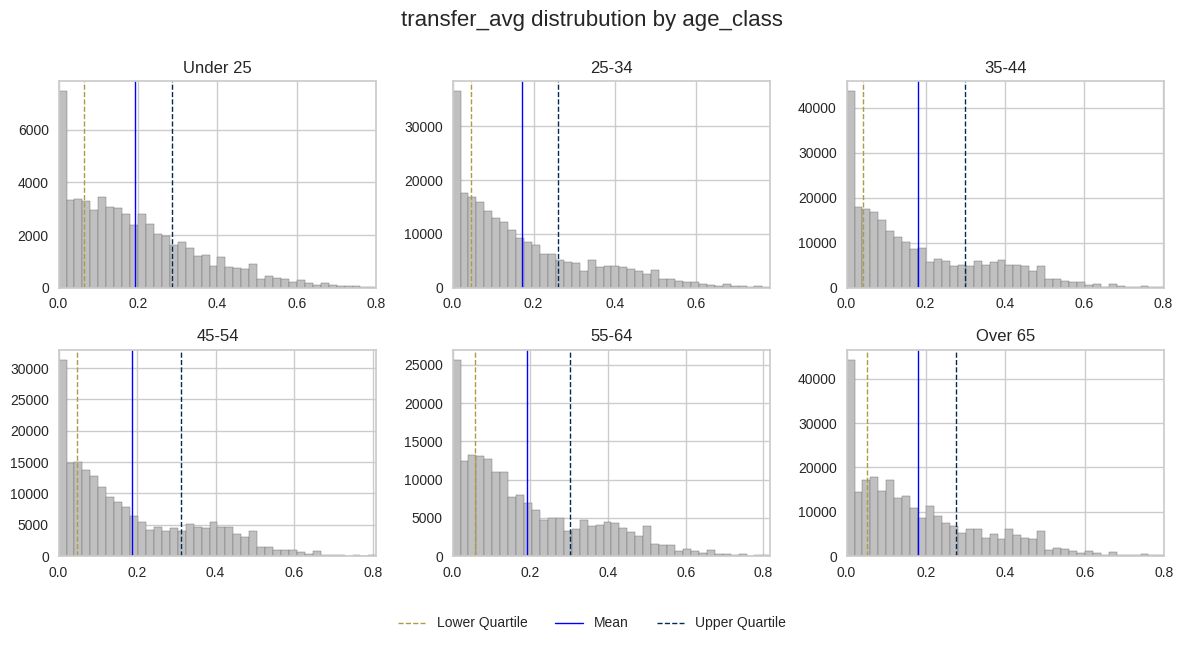

In [ ]:
hist_plotter(filtered_age_class_dfs, 'transfer_avg', 'age_class')

The histograms for each age class skew to the right.  The Under 25 Age Class histogram follows a negative curve indicating the most common transfer average amount is $0.  This trend is similar for the other age classes, however, for each age class, there is an increase of members who have a proportion of 0.4.  This increase is especially prominent in the 35-44 age class with almost 10,000 members having a proportion of transfers being 0.4.  On average , roughly 20% of transactions made by each age group consist of transfers.  

###Avg_tx_amt Histogram

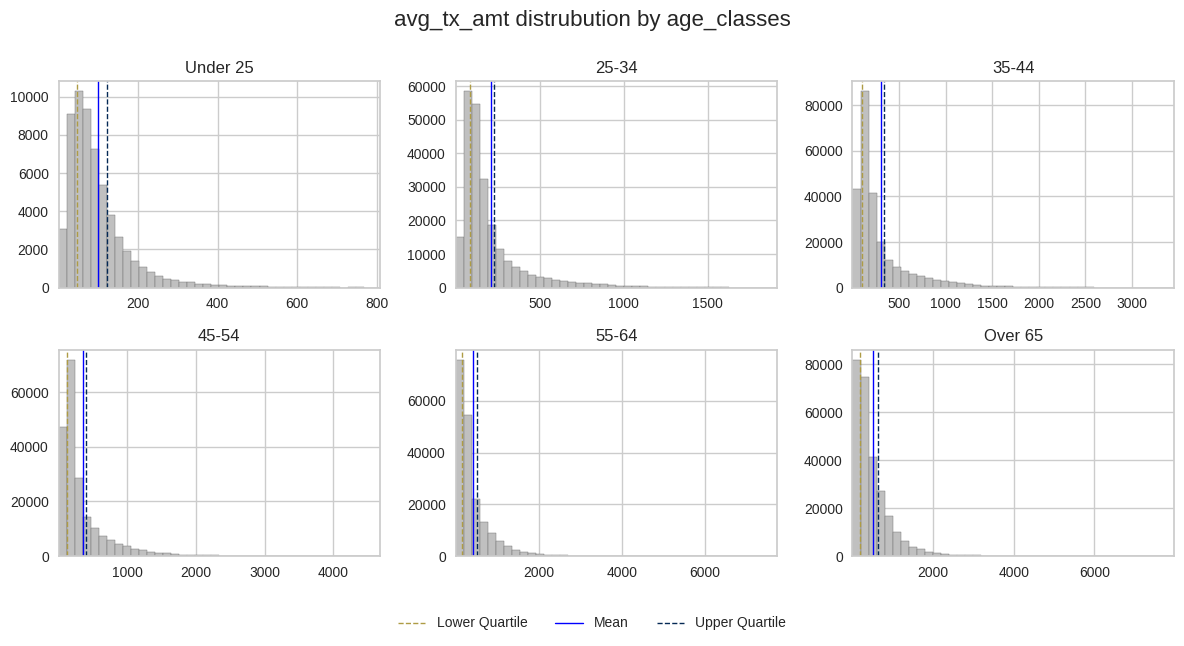

In [ ]:
hist_plotter(filtered_age_class_dfs, 'avg_tx_amt', 'age_classes')

In each age class, the data for `avg_tx_amt` skews to the right.

The Under 25 age class has the smallest range of values between \$0 and \$500 while 55-64 and Over 65 have the largest range between \$0 and \$1800.  This could be because older members have more financial obligations such as bills, or because they are spending more on comfort and luxury expenses.  Younger members may have less financial obligations.  

###Balance_avg Histogram

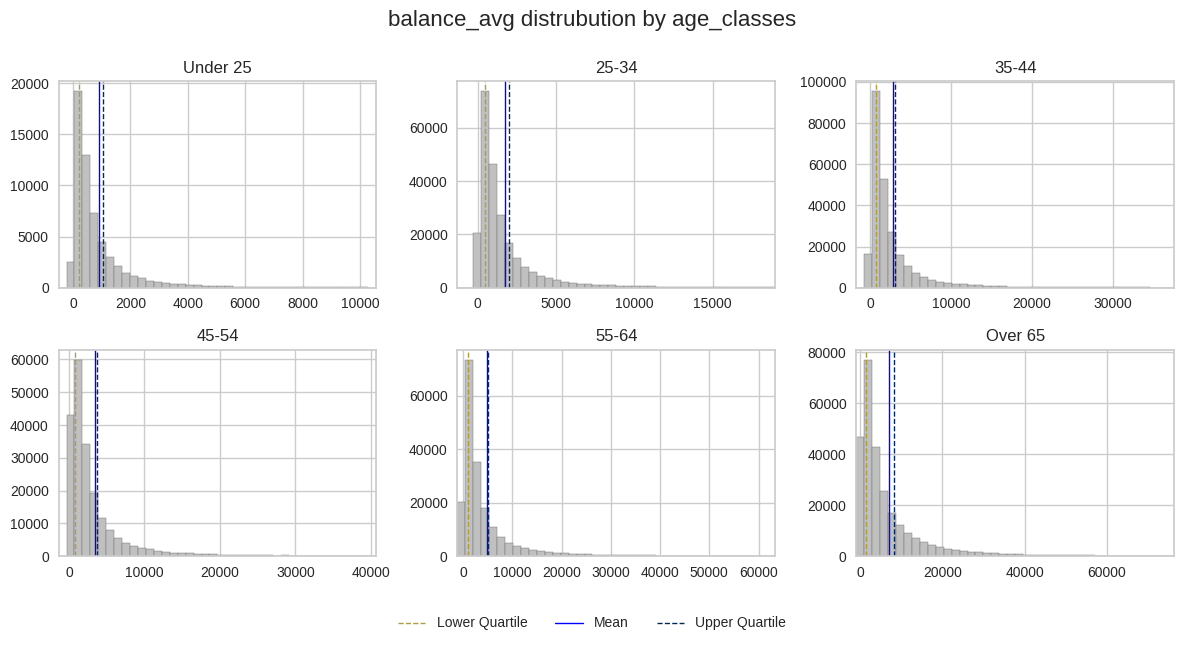

In [ ]:
hist_plotter(filtered_age_class_dfs, 'balance_avg', 'age_classes')

Similar to the `avg_tx_amt` histograms, the `avg_balance` histograms skew to the right.  The Under 25 age class has the smallest range of values between \$0 and \$8000.  Additionally, Over 65 has the largest range of values between \$0 and \$40000.  

###Avg_balance_change Histogram

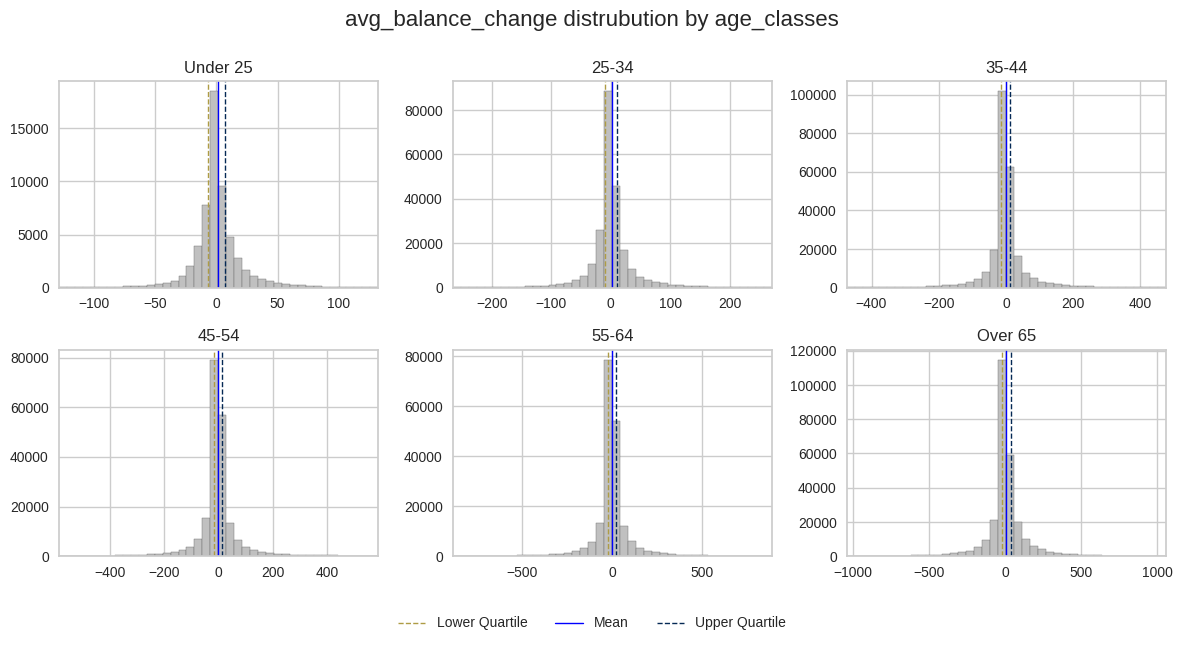

In [ ]:
hist_plotter(filtered_age_class_dfs, 'avg_balance_change', 'age_classes')

In each age class, the `avg_balance_change` histograms follow a bell shaped curve with the majority of the data being close to \$0.  This means that most members' account balance does not change in the month.  However, this could be because their deposits and withdrawals cancel out, or because they do not make transactions.

Similar to the previous histograms, the Under 25 age class has the smallest range of values between -\$100 to \$100 and Over 65 has the largest range of vales between -\$250 to \$300.  

###Card_avg Histogram

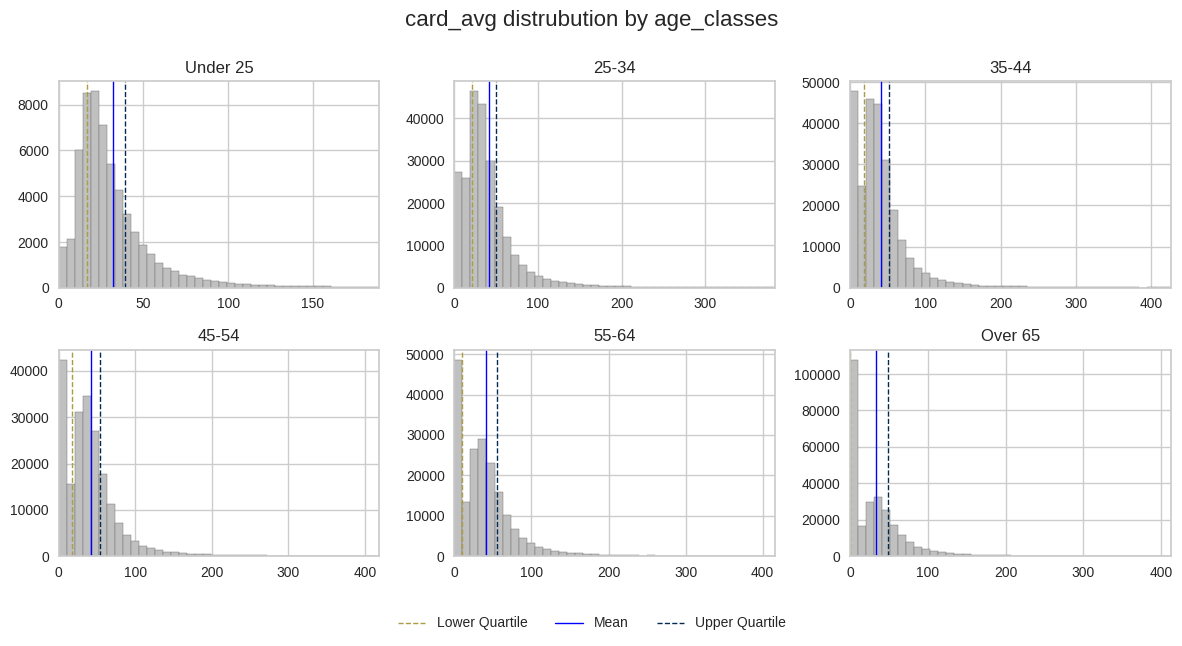

In [ ]:
hist_plotter(filtered_age_class_dfs, 'card_avg', 'age_classes')

These historgrams all skew to the right which means there could be some outliers towards the higher card average amounts.  This shows that there are some members who spend a large amount of money with their credit card.  The average amount of money spent falls around the \$50 range for each age group.  Interestingly, each age group has dollar ammounts ranging between \$0 and \$450, except for Under 25 which ranges between \$0 and \$200.  

##Methods

### Mathematical Models in Project

#### ARIMA Time Series model

[ARIMA](https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp)  stands for Autoregressive Integrated Moving Average and is a statistical model that uses time series data to help predict future values.  
- Autogressive (AR): Autoregressive refers to a model with a changing variable that regresses on its prior (lagged) values
- Integrated (I): Integrated refers to utilizing differencing to allow the data to be stationary
- Moving Average (MA): Moving Average refers to the dependency between an observation and residual error

These three components also make up the three parameters used in the ARIMA model.
- p (AR): The number of lag observations in the model
- d (I): The number of times the series is differenced to achieve stationarity
- q(MA): The number of lagged forecast errors included in the model

#### Data Transformation --- Standardization and Normalization

Standardization and normalization will be explained further in subsequent sections, but here is a brief overview:

Standardization: Transforming data to have a mean of 0 and a standard deviation of 1 by subtracting the mean and dividing by the standard deviation.

Normalization: Scaling the data to a fixed range (usually 0 to 1) by subtracting the minimum value and dividing by the range (difference between maximum and minimum values).

###Creating Account Health Score


#####Normalized Account Health Score

Here, we used the `MinMaxScaler()` function from `sklearn.preprocessing` to scale the data.

> The [MinMax scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) is a type of feature scaling technique used in data preprocessing. It rescales the data to a fixed range, usually between 0 and 1, by subtracting the minimum value of the feature and then dividing by the range (maximum value minus minimum value) of the feature.

> The formula used in normalizing is:
$$X_{scaled} = \frac{X-X_{min}}{X_{max}-X_{min}}$$

> The account health score is then created by taking the mean of the noramlized values across the columns for each row.  

In [ ]:
normalized_df = test_df_filtered.copy()

# Exclude categorical columns from normalization
columns_to_normalize = [col for col in test_df_filtered.columns if col not in
                        ['member_identifier', 'month_begin_date', 'age_class',
                         'median_hh_income_class','in_branch_avg', 'transfer_avg']]

columns_to_adjust = columns_to_normalize

mmscaler = MinMaxScaler()
normalized_df[columns_to_normalize] = mmscaler.fit_transform(normalized_df[columns_to_normalize])

# Calculate the account health score using multiple columns
normalized_df['normalized_ah_score'] = normalized_df.iloc[:,2:15].mean(axis=1) #.iloc[:,2:15] is the integer column location of columns_to_adjust

#####Standardized Account Health Score

We also used the `StandardScaler()` function from `ssklearn.preprocessing` to scale the data.
> [Standardizing](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) the dataset is a process that involves removing the mean of a variable from a data point and scaling that difference by the variance.  After scaling, the mean will be 0, and standard deviation will be 1.  A common misconception is that standardizing the data transforms it to a normal distribution.  However, this is not true.  Scaling the dataset is useful because it ensures that all features influence the account health score.  

> The formula used for scaling the data is:
$$z = \frac{x-mean(x)}{std(x)}$$

> The account health score is then found by taking the mean of the standardized values across the columns for each row.  

In [ ]:
standardized_df = test_df_filtered.copy()

sscaler = StandardScaler()
standardized_df[columns_to_adjust] = sscaler.fit_transform(standardized_df[columns_to_adjust])

# Calculate the account health score using multiple columns
standardized_df['standardized_ah_score'] = standardized_df.iloc[:,2:15].mean(axis=1)

In [ ]:
standardized_df = test_df_filtered.copy()

# Exclude categorical columns from normalization
columns_to_standardize = [col for col in standardized_df.columns if col not in
                          ['member_identifier', 'month_begin_date', 'age_class',
                           'median_hh_income_class', 'in_branch_avg', 'transfer_avg']]

sscaler = StandardScaler()
standardized_df[columns_to_standardize] = sscaler.fit_transform(standardized_df[columns_to_standardize])

# Calculate the account health score using multiple columns
standardized_df['standardized_ah_score'] = standardized_df.iloc[:,2:15].mean(axis=1)

In [ ]:
columns_to_normalize==columns_to_standardize

True

##Correlation Plot

Correlation plots can be helpful in determining whether there is colinearity, a direct and strong relationship, between variables.  

Based on this correlation plot, the variables with the highest amount of colinearity are `digital_success_tx_count` and `other_digital_tx_count`, `digital_success_tx_count` and `digital_login_count`, other_digital_tx_count` and digital_login_count`, and `count_deposit` and `count_withdrawal`.  

The variables related to digital transactions have high colinearity, but this is to be expected.  If a user logs in to their digital account and makes a transaction which is completed successfully, the corresponding metrics will be very similar.  Additionally, if a user makes many deposit transactions, they probably make many withdrawal transactions as well.    

Text(0.5, 1.0, 'Correlation Plot of Account Score Features')

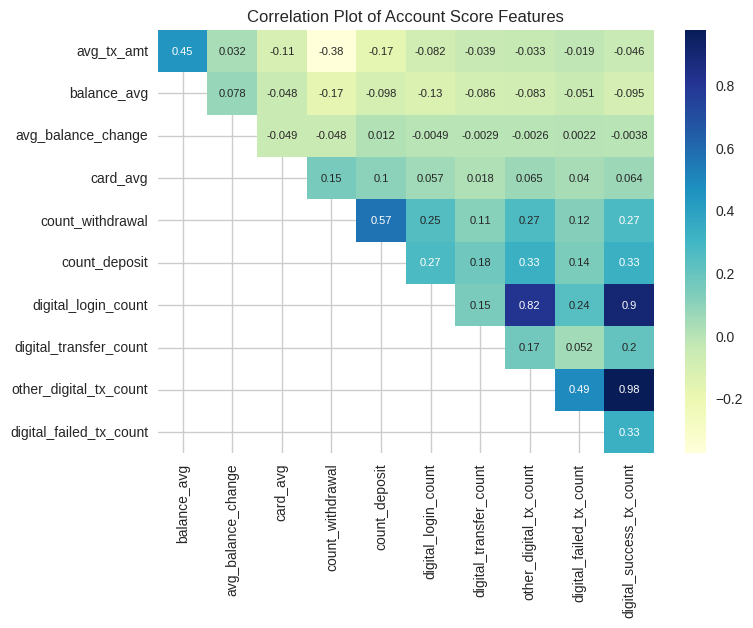

In [ ]:
corr = (lambda ρ : sns.heatmap(ρ, cmap="YlGnBu", annot=True,
                        mask=np.tril(np.ones_like(ρ), -1),
                        annot_kws={"size": 8}))(test_df_filtered[columns_to_adjust].corr().iloc[:-1, 1:])
corr.set_title('Correlation Plot of Account Score Features')

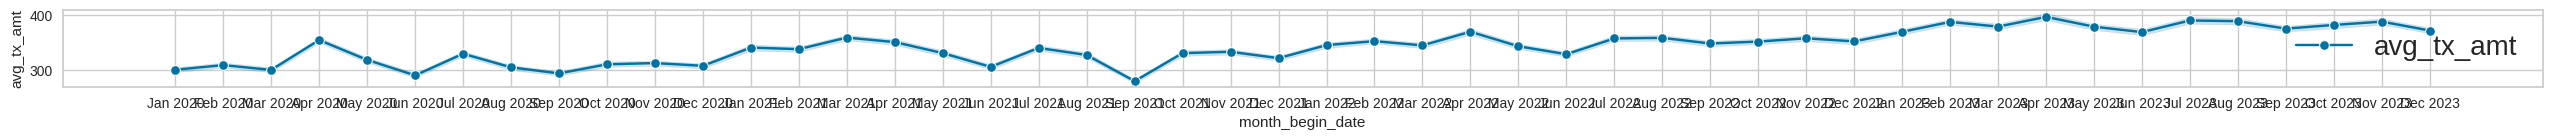

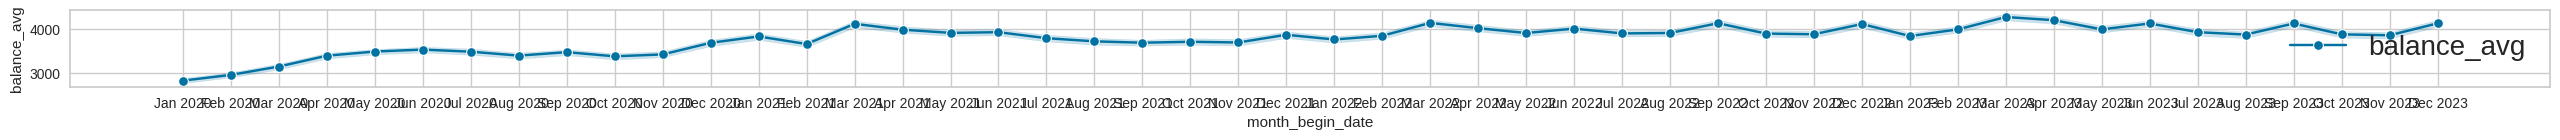

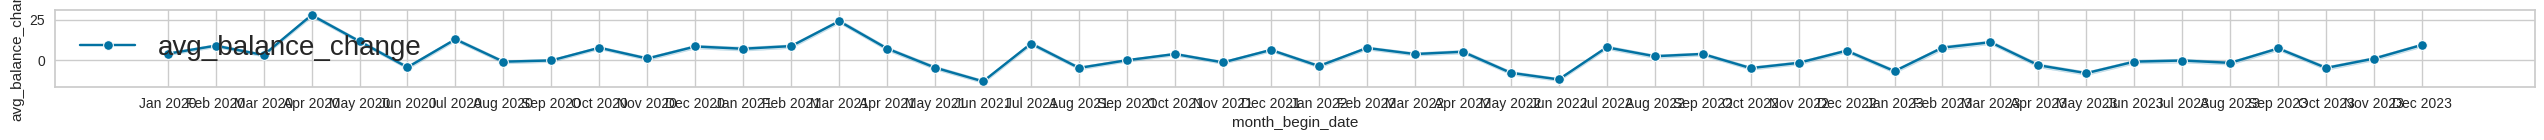

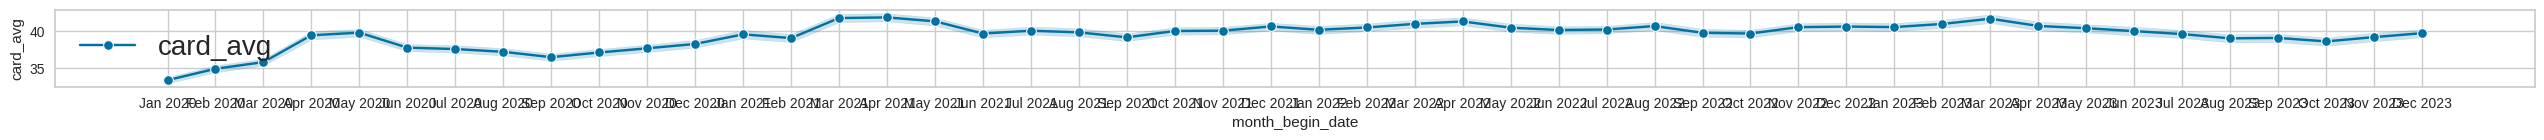

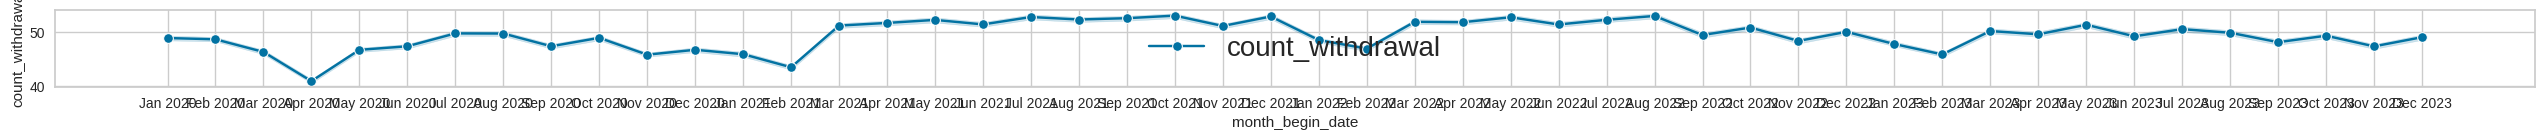

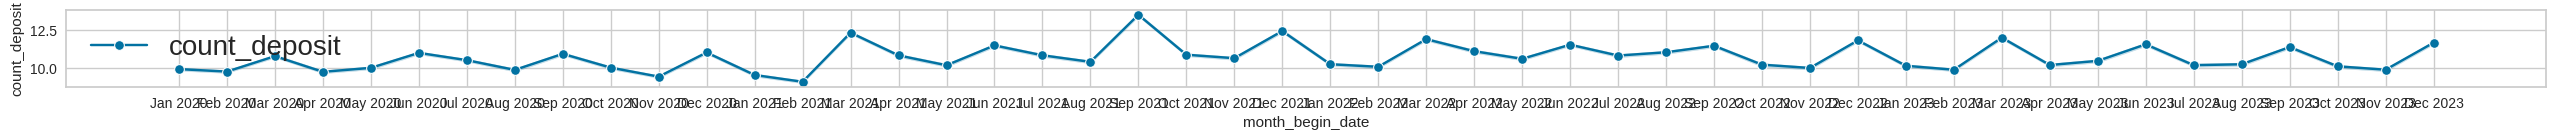

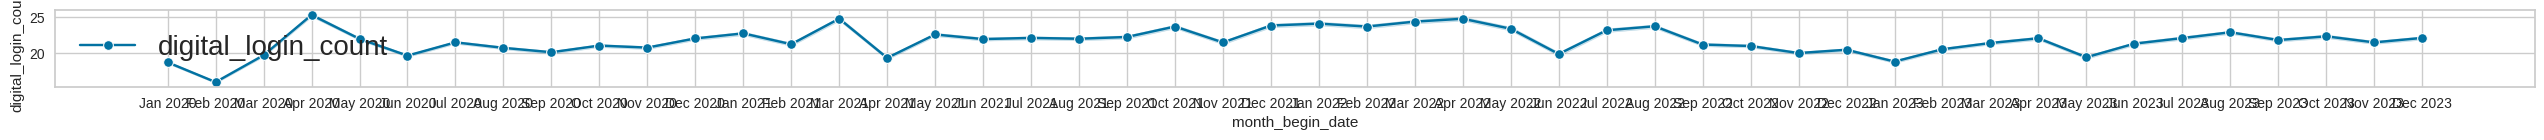

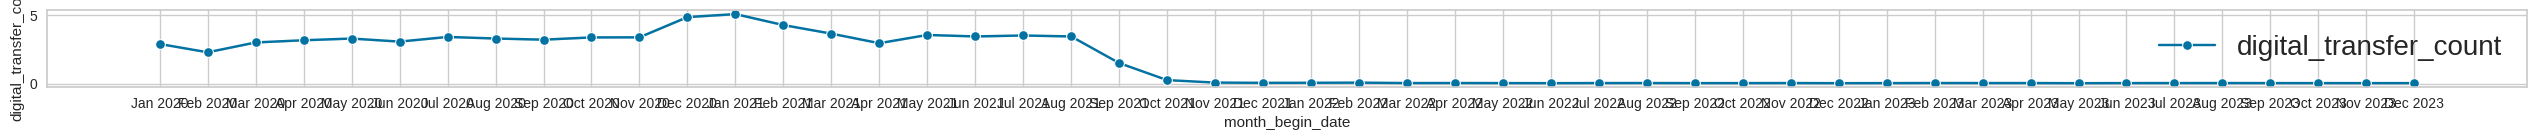

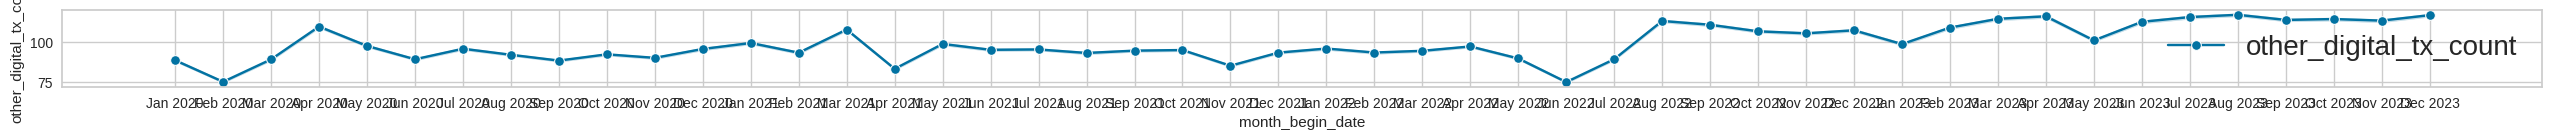

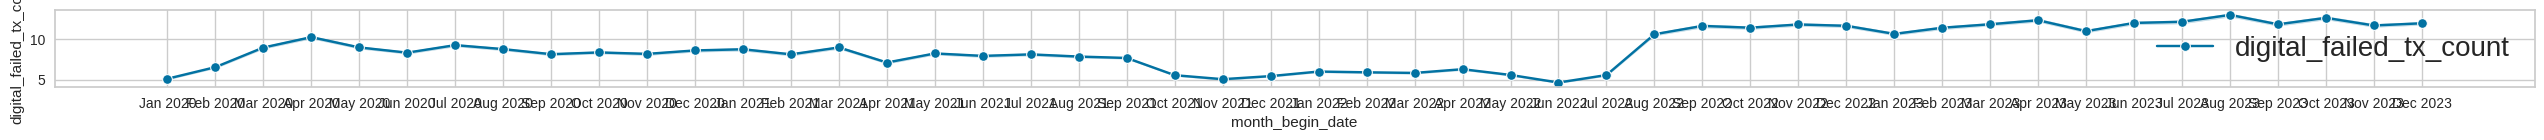

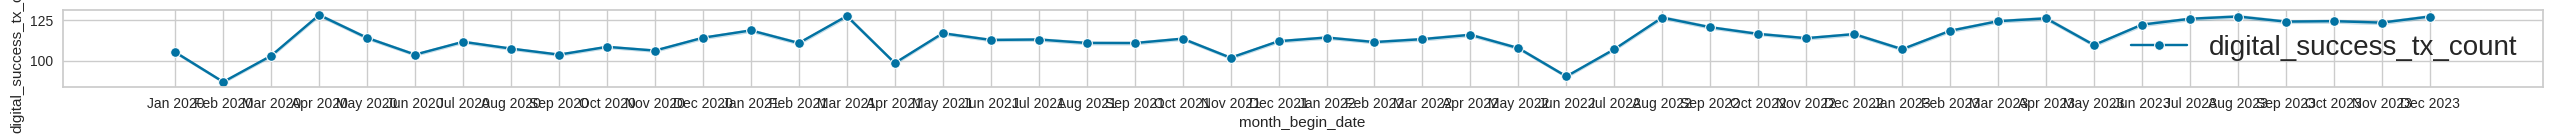

In [ ]:
for y in columns_to_normalize :
  plt.figure(figsize=(32,1))
  sns.lineplot(data=test_df_filtered, x='month_begin_date', y=y, marker="o", label=y)
  plt.legend(fontsize=20)
  plt.show()

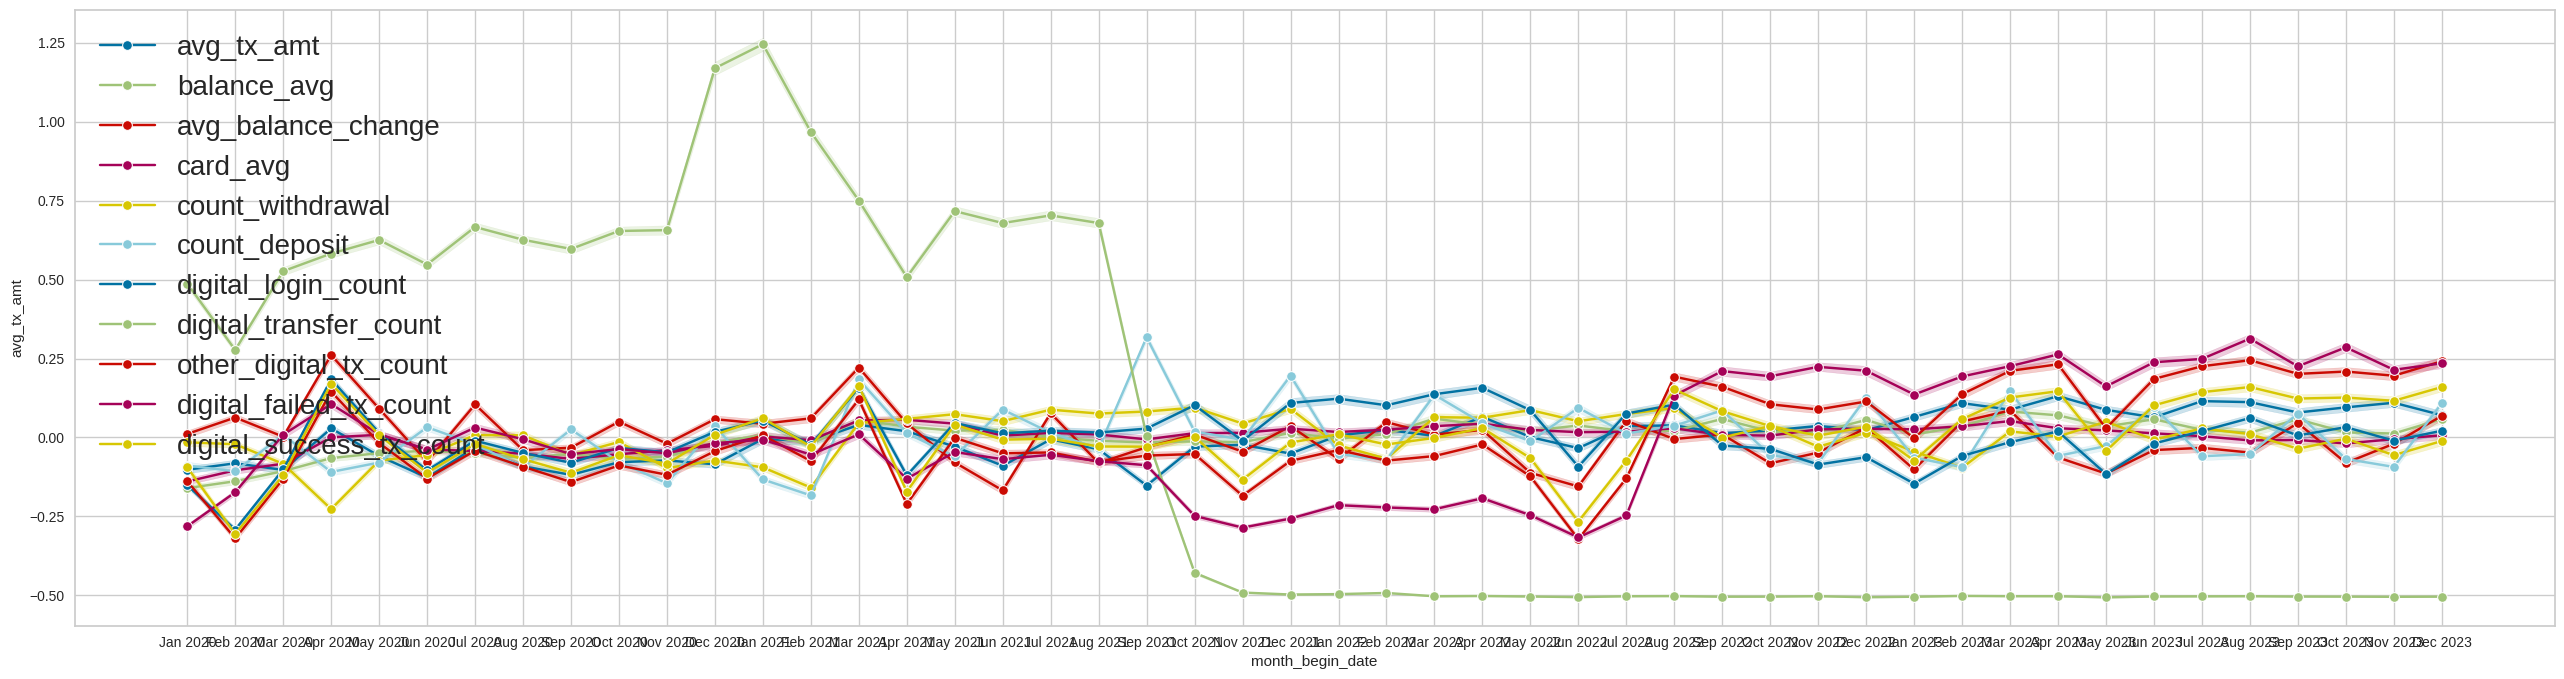

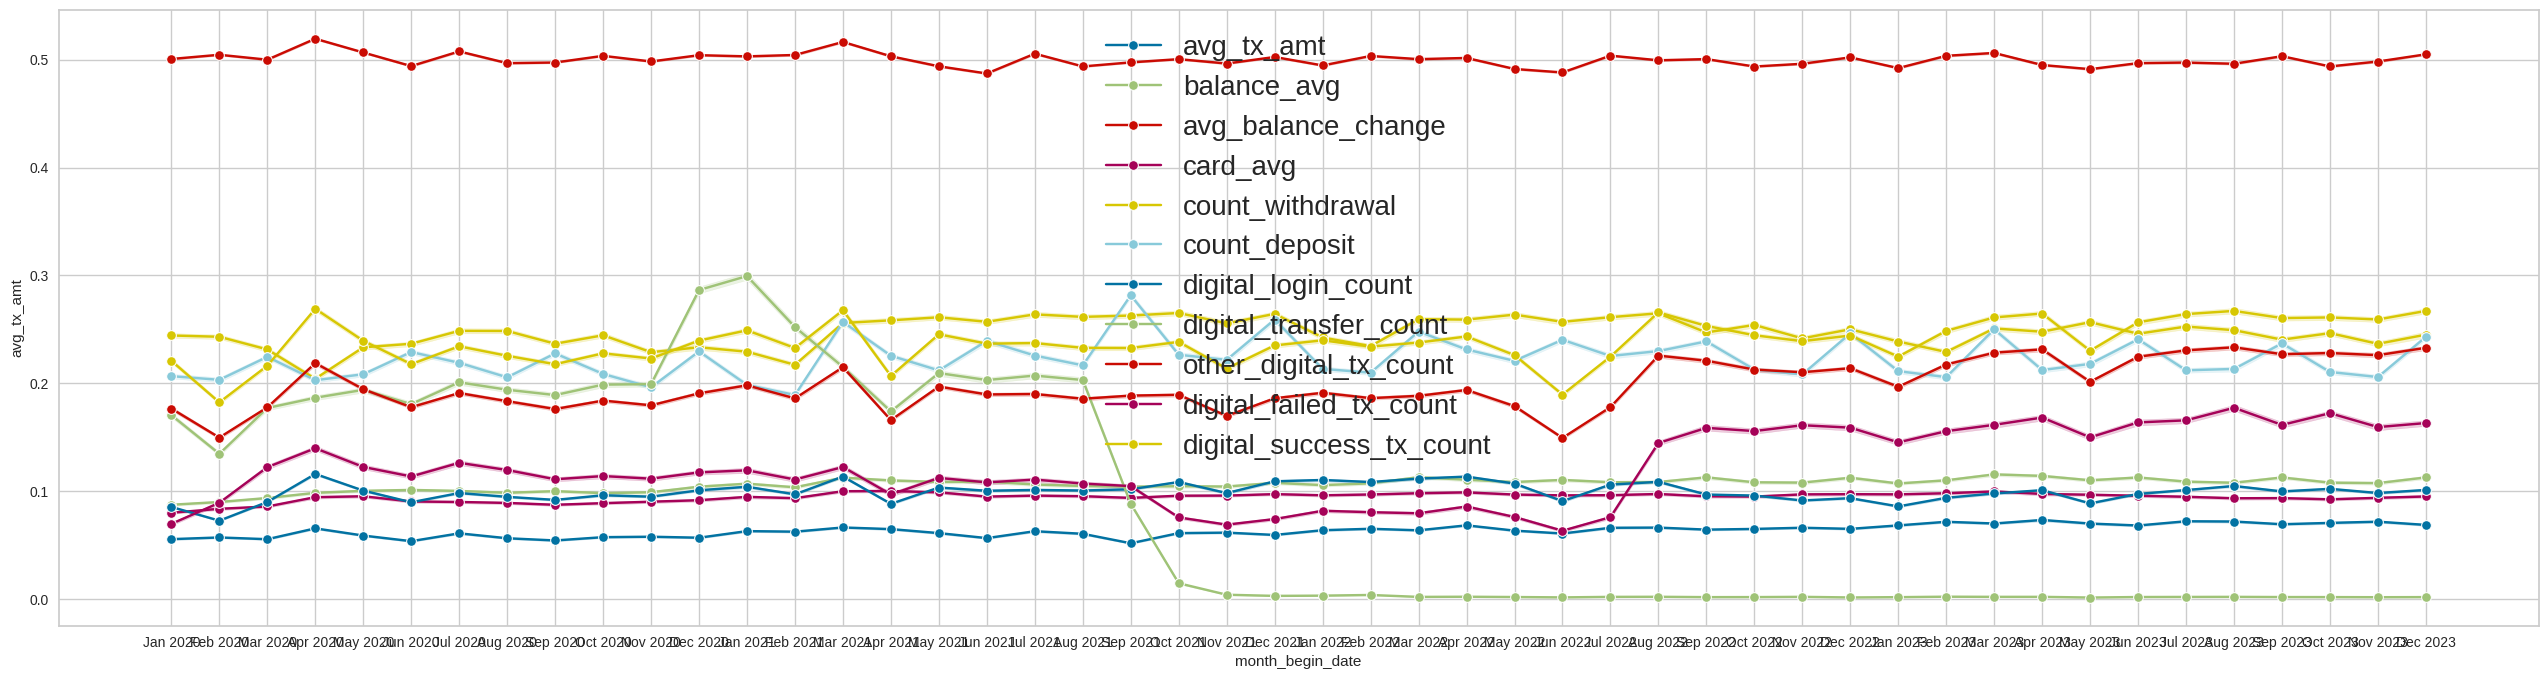

In [ ]:
plt.figure(figsize=(32,8))
for y in columns_to_normalize :
  sns.lineplot(data=test_df_filtered, label=y, marker="o", x='month_begin_date',
               y=stats.zscore(test_df_filtered[y]))
plt.legend(fontsize=20)
plt.show()
plt.figure(figsize=(32,8))
for y in columns_to_normalize :
  sns.lineplot(data=test_df_filtered, label=y, marker="o", x='month_begin_date',
               y=(lambda z : (z - z.min())/(z.max() - z.min()))(test_df_filtered[y]))
plt.legend(fontsize=20)
plt.show()

#####Normalization v. Standardization
Line Plot for Normalized v. Standardized AH Score

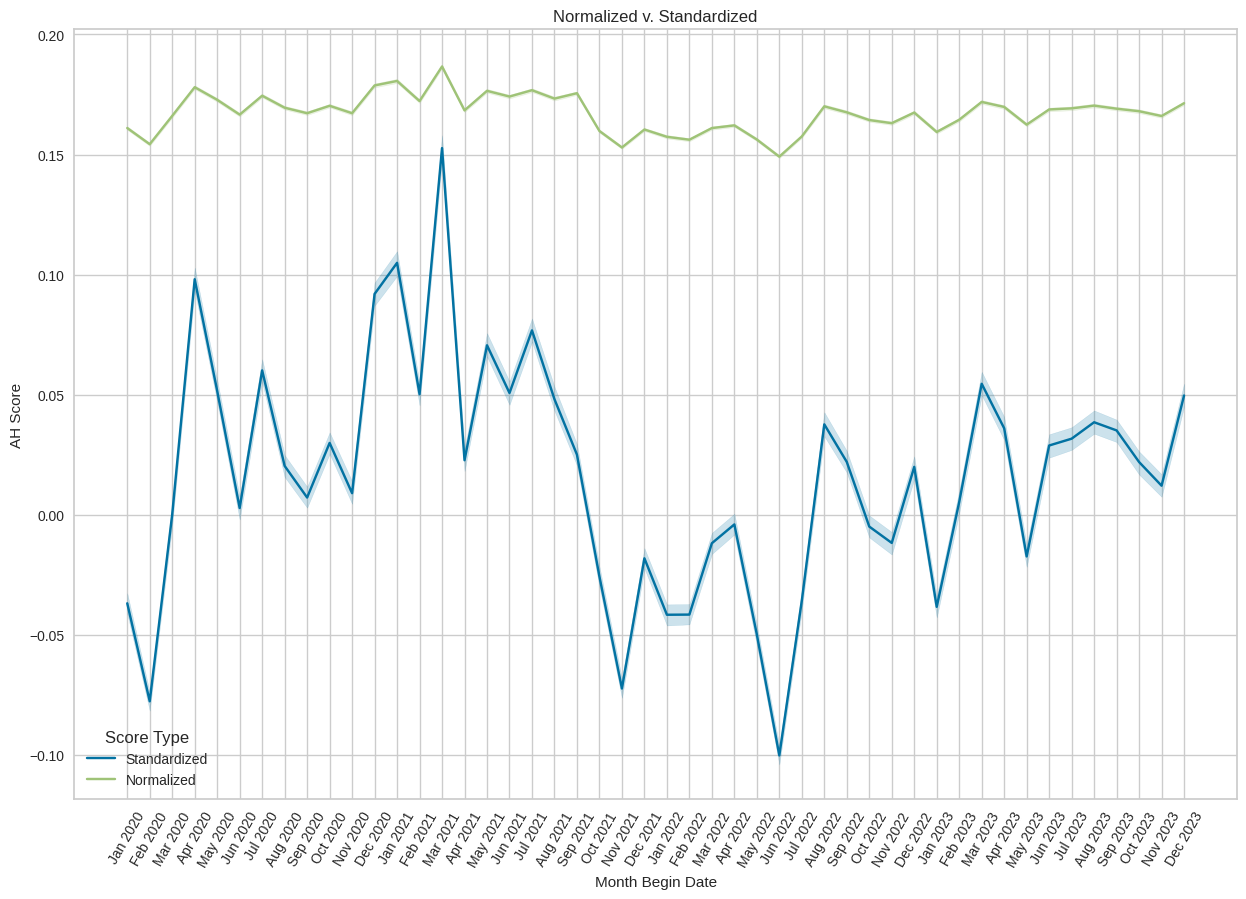

In [ ]:
# Show plot for normalized v. Standardized account health score
plt.figure(figsize=(15, 10))

# Plot the standardized AH scores
sns.lineplot(data=standardized_df, x='month_begin_date', y='standardized_ah_score', label='Standardized')
# Plot the normalized AH scores
sns.lineplot(data=normalized_df, x='month_begin_date', y='normalized_ah_score', label='Normalized')

plt.xticks(rotation=60)
plt.title('Normalized v. Standardized')
plt.xlabel('Month Begin Date')
plt.ylabel('AH Score')
plt.legend(title='Score Type')
plt.show()

**Interpretation of Standardized AH Score**

The standardized account health score shows some notable features such as a major dip in June 2022.  Additionally, the maximum account health score is at March 2021.  There is also a 4 month trend which can be seen through the cyclical nature of local minima and maxima.  

**Interpretation of Normalized AH Score**

The normalized account health score has its maximum at March 2021 and its minimum at June 2022.  There is significantly less obvious 4 month seasonallity compared to the the standardized health score.


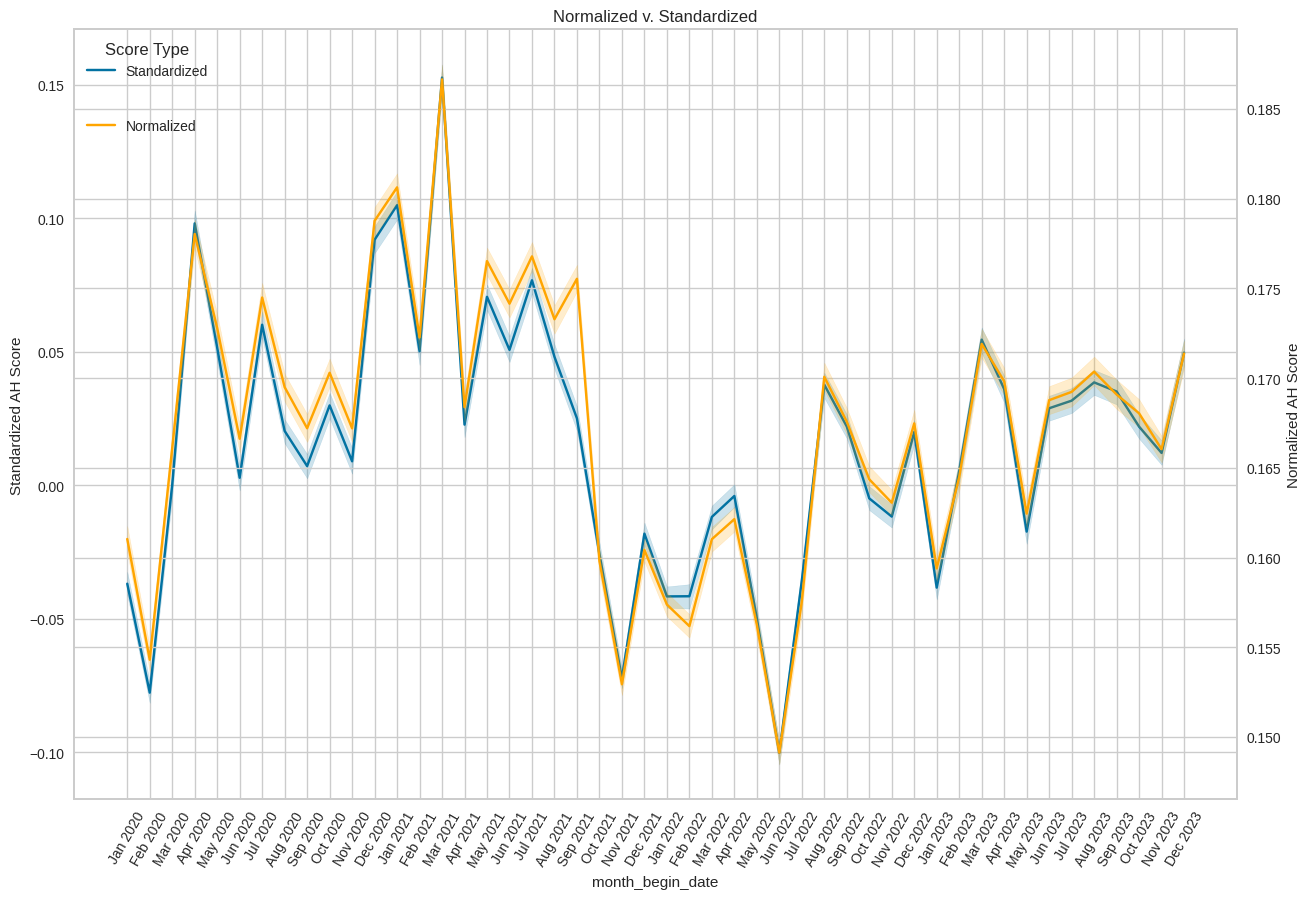

In [ ]:
# Plots both on separate y-axes

fig, ax1 = plt.subplots(figsize=(15, 10))

# Plot the standardized AH scores
sns.lineplot(data=standardized_df, x='month_begin_date', y='standardized_ah_score', ax=ax1, label='Standardized')
ax1.set_ylabel('Standardized AH Score')

# Create twin axes for normalized score
ax2 = ax1.twinx()
sns.lineplot(data=normalized_df, x='month_begin_date', y='normalized_ah_score', ax=ax2, color='orange', label='Normalized')

ax2.set_ylabel('Normalized AH Score')

# Rotate x-axis labels within Seaborn's lineplot function
ax1.tick_params(axis='x', rotation=60)

plt.xlabel('Month Begin Date')
plt.title('Normalized v. Standardized')

ax1_legend = ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), title='Score Type')
ax2_legend = ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

plt.show()


When plotting both the standardized and normalized account health scores on the same y axis, one may seem more dramatic than the other.  However, when plotted on separate y axes the difference between the two in terms of shape and trend is less noticable.  This is because the standardized account health score and normalized account health score are created from the same dataset, only undergoing different preprocessing techniques.   

####Age Class AH Scores

#####Normalized AH Scores per Age_class

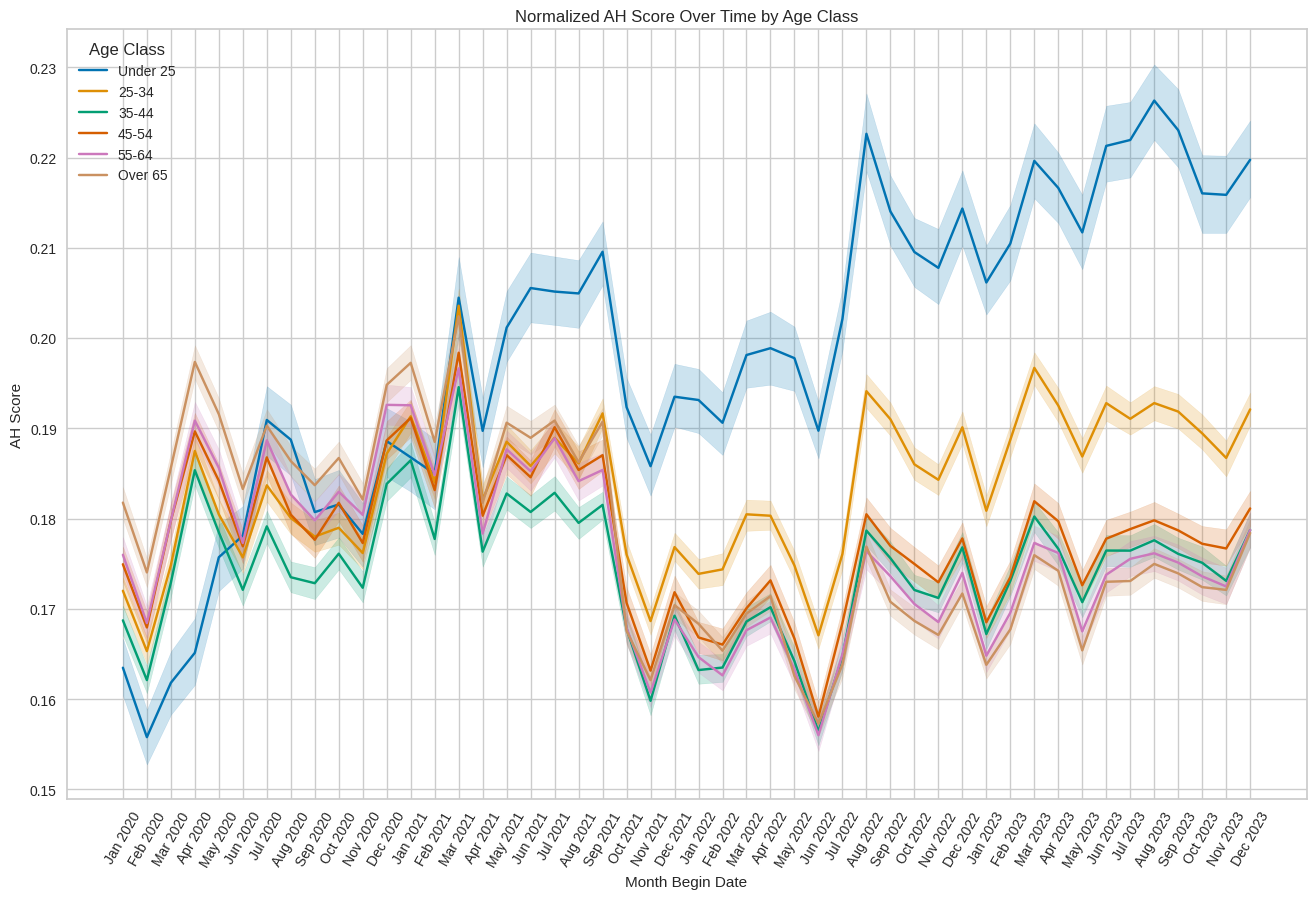

In [ ]:
warnings.filterwarnings('ignore')
mmscaler=MinMaxScaler()
colors = sns.color_palette("colorblind", n_colors=len(filtered_age_class_dfs))

# Create new Normalized AH Score for each of the Age
for age_class, df in filtered_age_class_dfs.items():
    df_copy = df.copy()
    # Exclude categorical columns from normalization
    columns_to_normalize = [col for col in df_copy.columns if col not in
                            ['member_identifier', 'month_begin_date', 'age_class', 'median_hh_income_class']]

    df_copy[columns_to_normalize] = mmscaler.fit_transform(df_copy[columns_to_normalize])

    # Calculate the account health score using multiple columns
    df_copy['seg_norm_ah_score'] = df_copy.iloc[:,2:15].mean(axis=1)

    # Update the DataFrame in your dictionary with the new columns
    filtered_age_class_dfs[age_class]['seg_norm_ah_score'] = df_copy['seg_norm_ah_score']

plt.figure(figsize=(16, 10))
for i, ((age_class), df) in enumerate(filtered_age_class_dfs.items()):
    sns.lineplot(data=df, x='month_begin_date', y='seg_norm_ah_score', label=f'{age_class}', color=colors[i])
plt.xticks(rotation=60)
plt.legend(title='Age Class')
plt.title('Normalized AH Score Over Time by Age Class')
plt.xlabel('Month Begin Date')
plt.ylabel('AH Score')
plt.show()

This graph breaks down the normalized account health score by age class.  All of the age groups share similar trends with a large peak around March 2021 and a 3 month trend cycle.  One major difference is the Under 25 age group's overall account health increases after November 2021 compared to the other age groups  The sponsor noted this is likely because the Under 25 age group went from teenagers who were not too involved with their account to tech-savvy adults who engaged more frequently.   

#####Standardized AH Scores per Age_class

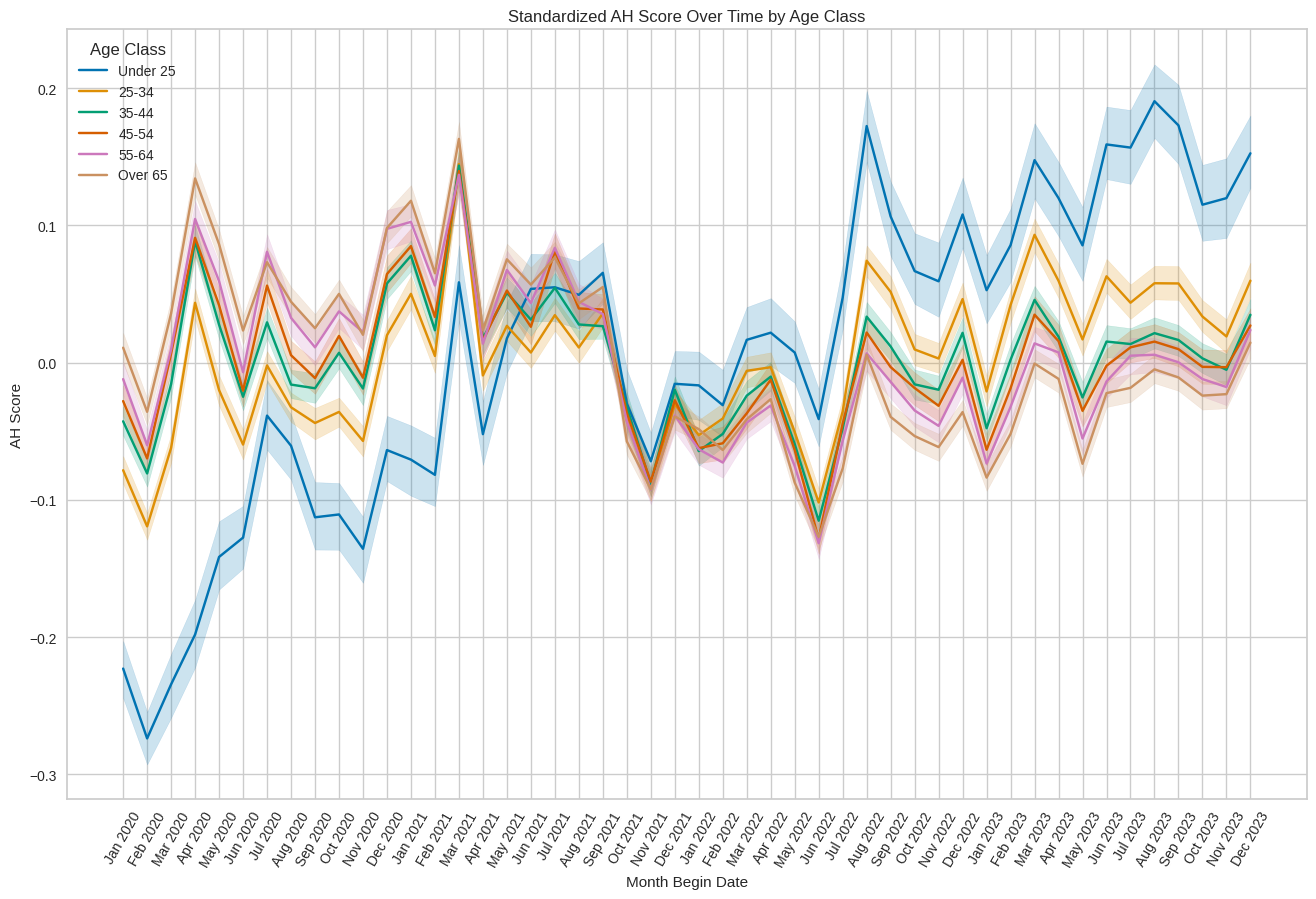

In [ ]:
sscaler = StandardScaler()
colors = sns.color_palette("colorblind", n_colors=len(filtered_age_class_dfs))
for age_class, df in filtered_age_class_dfs.items():
    df_copy = df.copy()
    # Exclude categorical columns from normalization
    columns_to_standardize = [col for col in df_copy.columns if col not in
     ['member_identifier', 'month_begin_date', 'age_class', 'median_hh_income_class', 'seg_norm_ah_score']]

    df_copy[columns_to_standardize] = sscaler.fit_transform(df_copy[columns_to_standardize])

    # Calculate the account health score using multiple columns
    df_copy['seg_stan_ah_score'] = df_copy.iloc[:,2:15].mean(axis=1)

    filtered_age_class_dfs[age_class]['seg_stan_ah_score'] = df_copy['seg_stan_ah_score']

plt.figure(figsize=(16, 10))
for i, ((age_class), df) in enumerate(filtered_age_class_dfs.items()):
    sns.lineplot(data=df, x='month_begin_date', y='seg_stan_ah_score', label=f'{age_class}', color=colors[i])
plt.xticks(rotation=60)
plt.legend(title='Age Class')
plt.title('Standardized AH Score Over Time by Age Class')
plt.xlabel('Month Begin Date')
plt.ylabel('AH Score')
plt.show()

This graph shows the account health scores split by age class based on the standardized data set.  Interestingly, between August 2021 and July 2022, all age classes have a very similar account health score.  Based on the shaded region around each line, the Under 25 age group has the largest amount of variability.  

One downside to the standardized account health score is that it includes negative values.  This can be difficult to interpret.

#####Normalized v. Standardized Scores by Age Class

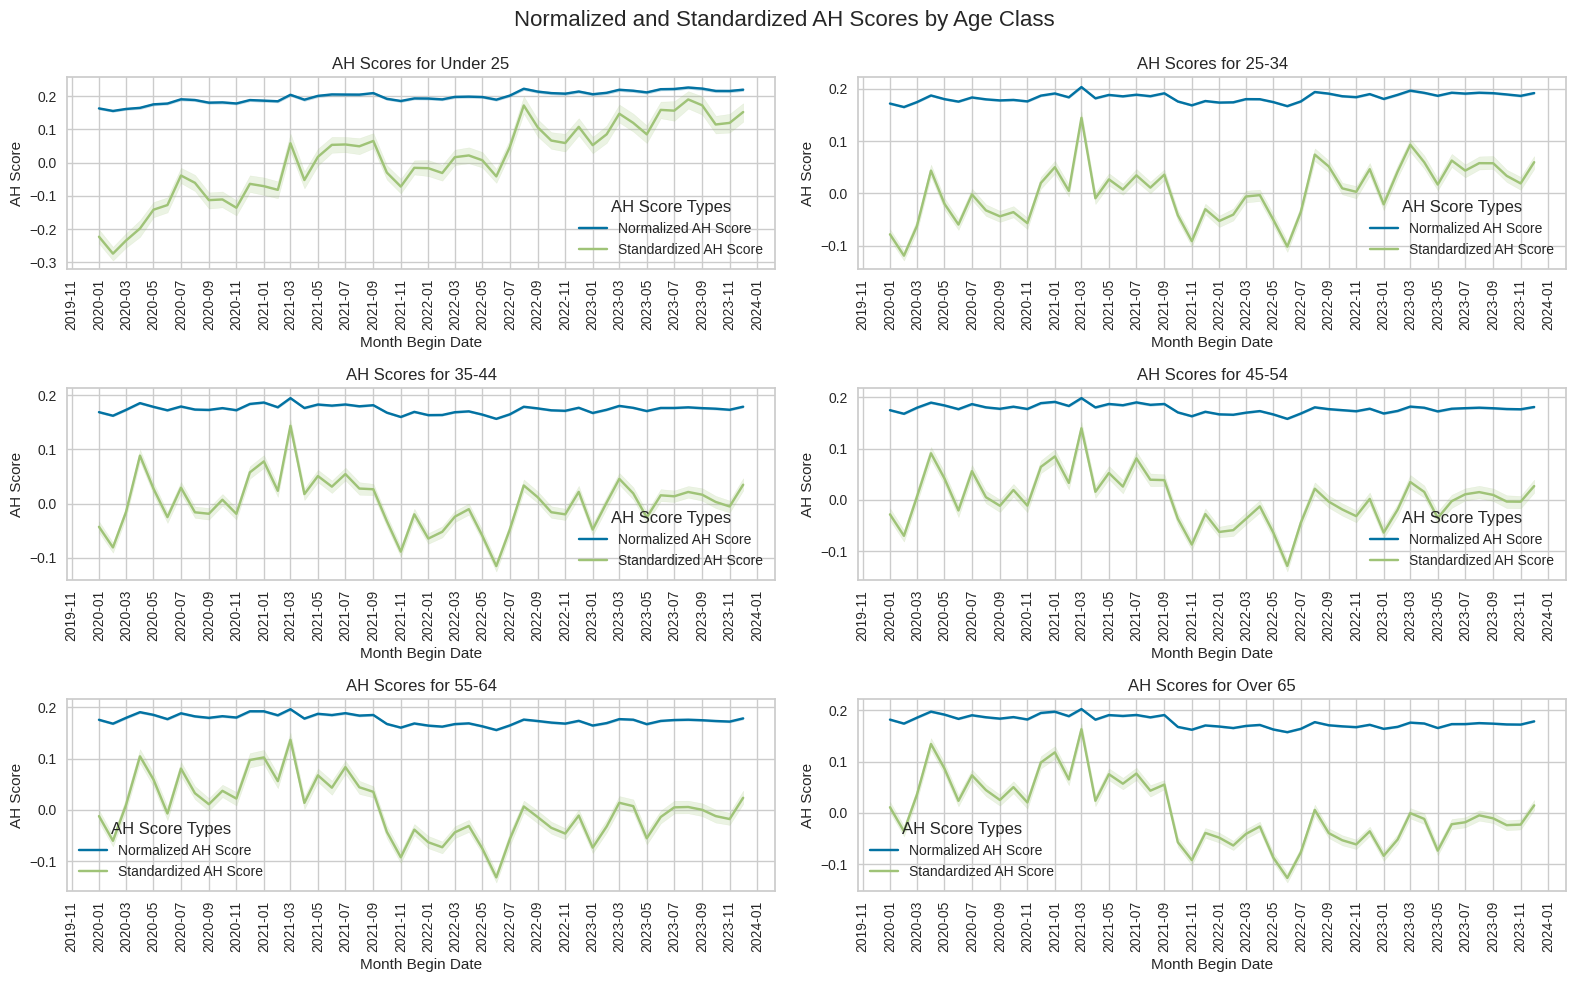

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
fig.suptitle('Normalized and Standardized AH Scores by Age Class', fontsize=16)
axes = axes.flatten()
# Iterate over the filtered_age_class_dfs dictionary
for i, (age_class, df) in enumerate(filtered_age_class_dfs.items()):
    df['month_begin_date'] = pd.to_datetime(df['month_begin_date'])
    ax = axes[i]

    sns.lineplot(data=df, x='month_begin_date', y='seg_norm_ah_score', ax=ax, label='Normalized AH Score')
    sns.lineplot(data=df, x='month_begin_date', y='seg_stan_ah_score', ax=ax, label='Standardized AH Score')

    # Set x-axis major locator to every 2 months and formatter
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_title(f'AH Scores for {age_class}')
    ax.set_xlabel('Month Begin Date')
    ax.set_ylabel('AH Score')
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels
    ax.legend(title='AH Score Types')
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

This graph shows the normalized and standardized account health scores for each age class.  Although each age class tends to show similar patterns with peaks around March 2021 and November 2023, there are some other trends worth noting.  

The Under 25 age class's standardized and normalized account health score increases over time and does not suffer as dramatic of a dip in September 2021 as the other age classes.  

The standardized account health score for the Under 25, 25-34, and Over 65 age classes have the largest range between -0.2 and 0.2.





#### Building an Optimal ARIMA Order Finder Function

In [ ]:
def arima_order_finder(df, score_type:str, min_p:int, min_d:int, min_q:int, max_p:int, max_d:int, max_q:int):
    """
    The following function iterates through a specified minimum and maximum p, d, q value and
    evaluates the minimum mean absolute difference (normalized by mean of actual training set)
    of training predictions to determine the optimal ARIMA model. The results are then printed,
    and the actual data is plotted against the train and test predictions of the optimal model.

    df: dataframe containing desired score to apply funciton to
    score_type: column name containing the score the function is applied to
    min_p (int): minimum p value
    min_d (int): minimum d value
    min_q (int): minimum q value
    max_p (int): maximum p value
    max_d (int): maximum d value
    max_q (int): maximum q value)
    """
    # Define parameter ranges
    p_values = range(min_p, max_p)
    d_values = range(min_d, max_d)
    q_values = range(min_q, max_q)

    df['month_begin_date'] = pd.to_datetime(df['month_begin_date'])
    # Split into training and test sets
    train = df[df['month_begin_date'] <= '2022-12-01']
    test = df[df['month_begin_date'] >= '2023-01-01']

    # Initialize variables for optimal order and minimum error metric
    optimal_order = None
    min_error = float('inf')

    # Iterate over all parameter combinations
    for p, d, q in itertools.product(p_values, d_values, q_values):
        order = (p, d, q)

        # Fit ARIMA model
        model = ARIMA(train[score_type], order=order)
        model_fit = model.fit()

        # Make predictions for the test period
        train_predictions = model_fit.predict(start=0, end=len(train) - 1, typ='levels')
        test_predictions = model_fit.predict(start=len(train), end=len(train) + len(test) -1)

        # Calculate mean of absolute differences normalized by mean of actual training set
        normalized_mean_absolute_error = np.mean(np.abs(train_predictions - train[score_type]))/np.mean(train[score_type])

        # Find minimum normalized_mean_absolute_error
        if normalized_mean_absolute_error < min_error:
            min_error = normalized_mean_absolute_error
            optimal_order = order
            optimal_train_predictions = train_predictions
            optimal_test_predictions = test_predictions

    # Print the optimal ARIMA order and corresponding normalized_mean_absolute_error metric
    print(f"Optimal ARIMA Order: {optimal_order}")
    print(f"Minimum Mean of Absolute Differences: {min_error}")

    # Create DataFrames for optimal train and test predictions
    train_prediction_index = pd.date_range(start='2020-01-01', periods=36, freq='MS')
    optimal_train_pred_df = pd.DataFrame({"month_begin_date": train_prediction_index, 'optimal_train_predictions': optimal_train_predictions})

    test_prediction_index = pd.date_range(start='2023-01-01', periods=12, freq='MS')
    optimal_test_pred_df = pd.DataFrame({"month_begin_date": test_prediction_index, 'optimal_test_predictions': optimal_test_predictions})

    # plot actual data
    plt.figure(figsize=(12, 8))
    plt.plot(df['month_begin_date'], df[score_type], label='Actual Data', color='gray')
    # Add plots for predicted train & test data
    plt.plot(optimal_train_pred_df['month_begin_date'], optimal_train_pred_df['optimal_train_predictions'], label='Optimal Training Predictions', color='darkorange')
    plt.plot(optimal_test_pred_df['month_begin_date'], optimal_test_pred_df['optimal_test_predictions'], label='Optimal Test Predictions', color='blue')
    plt.title(f"Actual vs Predicted (Train & Test) {score_type} Optimal ARIMA Order {optimal_order} (based on training data)")
    plt.xlabel('Month Begin Date')
    plt.ylabel('AH Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Modeling Results and Discussion

###Whole Set Modeling

####Train/Test Data Split

To create the model, the data is split into "training data" and "testing data."  Training data consists of data before January 1, 2023 and testing data consists of data after and including January 1, 2023.  


The train test split method allows us to asses the performance of our model.  The model is "trained" through the training data and the results are then "tested" on our test data.  Because we have the testing data, we can directly compare the predicted results of the model to the actual results.  This also allows us to determine how well the model may do with new data.

In [ ]:
normalized_df['month_begin_date'] = pd.to_datetime(normalized_df['month_begin_date'])

# Sort the DataFrame by 'month_begin_date' to ensure chronological order
normalized_df = normalized_df.sort_values(by='month_begin_date')

# Specify the cutoff date for splitting the data into training and testing sets
cutoff_date = pd.to_datetime('2023-01-01')

# Split the DataFrame into training and testing sets
norm_train_df = normalized_df[normalized_df['month_begin_date'] < cutoff_date]
norm_test_df = normalized_df[normalized_df['month_begin_date'] >= cutoff_date]

# Check the shapes of the training and testing sets
print("Training set shape:", norm_train_df.shape)
print("Testing set shape:", norm_test_df.shape)

Training set shape: (927564, 18)
Testing set shape: (295372, 18)


#### Aggregate the score for entire set

In [ ]:
# Calculate the average 'ah_score' for each date in train_df
norm_monthly_avg_scores_train = norm_train_df.groupby('month_begin_date')['normalized_ah_score'].agg('mean')

# Calculate the average 'ah_score' for each date in each age_class of age_dfs
norm_monthly_avg_scores_test = norm_test_df.groupby('month_begin_date')['normalized_ah_score'].agg('mean')

#### Augmented Dickey-Fuller (ADF) Test for Whole Dataset

The [ADF test](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/) is used to determine whether a time series is stationary or not.  In this case, the null hypothesis is that a unit root is present in a time series sample.  The test will return a test statistic, p-value, and critical values.  The test statistic is a measure of how strongly a time series is trending.  The p-value indicates the probability of observing that test statistic. The critical values are critical at the given significance levels.  If the ADF test statistic is more negative at a given critical value, then the null hypothesis can be rejected, and conclude the time series is stationary.



In [ ]:
# Perform ADF test for the training set
adf_result_train = adfuller(norm_monthly_avg_scores_train)
print("ADF test results for training set:")
print("ADF Statistic:", adf_result_train[0])
print("p-value:", adf_result_train[1])
print("Critical Values:", adf_result_train[4], '\n')

# Perform ADF test for the test set
adf_result_test = adfuller(norm_monthly_avg_scores_test)
print("ADF test results for test set:")
print("ADF Statistic:", adf_result_test[0])
print("p-value:", adf_result_test[1])
print("Critical Values:", adf_result_test[4], '\n')

# Concatenate monthly average scores for train and test sets
combined_monthly_avg_scores = pd.concat([norm_monthly_avg_scores_train, norm_monthly_avg_scores_test])

# Perform ADF test for the combined dataset
adf_result_combined = adfuller(combined_monthly_avg_scores)
print("ADF test results for entire dataset:")
print("ADF Statistic:", adf_result_combined[0])
print("p-value:", adf_result_combined[1])
print("Critical Values:", adf_result_combined[4], '\n')

ADF test results for training set:
ADF Statistic: -2.9167145387486855
p-value: 0.0434385633733901
Critical Values: {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756} 

ADF test results for test set:
ADF Statistic: -2.5434884759133105
p-value: 0.10524837726266839
Critical Values: {'1%': -4.473135048010974, '5%': -3.28988060356653, '10%': -2.7723823456790124} 

ADF test results for entire dataset:
ADF Statistic: -3.5288674885091234
p-value: 0.007275938220204298
Critical Values: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064} 



Using a significance level of 0.05, the training set, testing set, and the combined data between training and testing are all stationary.


##### [ACF and PACF Plots](https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling#:~:text=Autocorrelation%20Function%20(ACF)&text=The%20ACF%20plots%20the%20correlation,value%20in%20the%20time%20series.)

ACF stands for autocorrelation function plot and shows the correlation between a time series and its lagged values. It helps determine the value of the parameter q (the order of the moving average component).

PACF stands for partial autocorrelation function plot and shows the correlation between a time series and its lagged values after removing the effects of shorter lags.It helps determine the value of the parameter p (the order of the autoregressive component).

The shaded region represents lags that are not statistically significant, meaning there is likely no correlation between the series and its lagged values.  

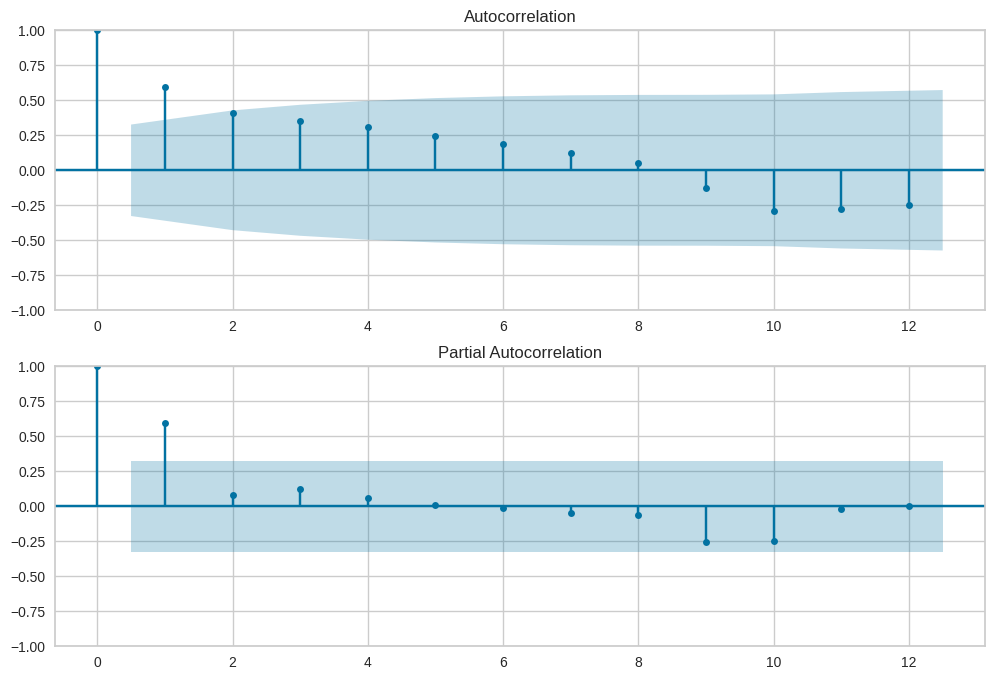

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(norm_monthly_avg_scores_train, ax=ax[0], lags=12)
plot_pacf(norm_monthly_avg_scores_train, ax=ax[1], lags=12)

plt.show()

When interpreting the ACF and PACF plots, we are looking for nodes that are statisticially significant, meaning they fall above the blue shaded region.   

In both the ACF plot and PACF plot, the first node represents the correlation of the time series with itself, and the value will always be 1.  

From both plots, we can see we want $q \le 1$ and $p \le 1$.

##### Normalized Model Buildup

In [ ]:
# Fit ARIMA model
model = ARIMA(norm_monthly_avg_scores_train, order=(10, 0, 5))
model_fit = model.fit()

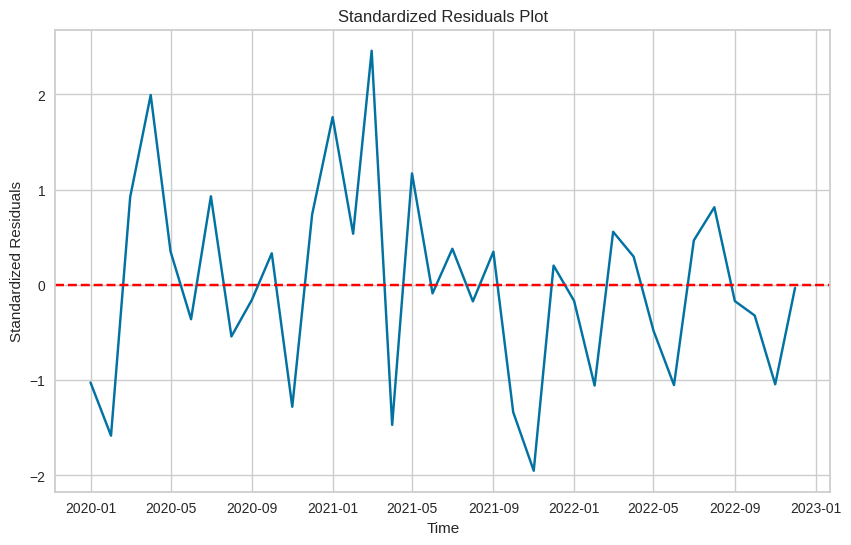

In [ ]:
# Plot standardized residuals
residuals = model_fit.resid

z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# Plot the standardized residuals
plt.figure(figsize=(10, 6))
plt.plot(z_scores)
plt.title('Standardized Residuals Plot')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Standardized Residuals')
plt.grid(True)
plt.show()

In this model, the entire normalized data set is used with the parameters (10, 0, 5).  
- $p=10$, meaning the number of lag observations is 10
- $d=0$, meaning the observations are not differenced
- $q=5$, meaning the size of the moving average window is 5


The graph plots the standardized residuals, which are the differences between the observed values and the expected values, divided by the standard deviation of the residuals.


##### Test Set Predictions

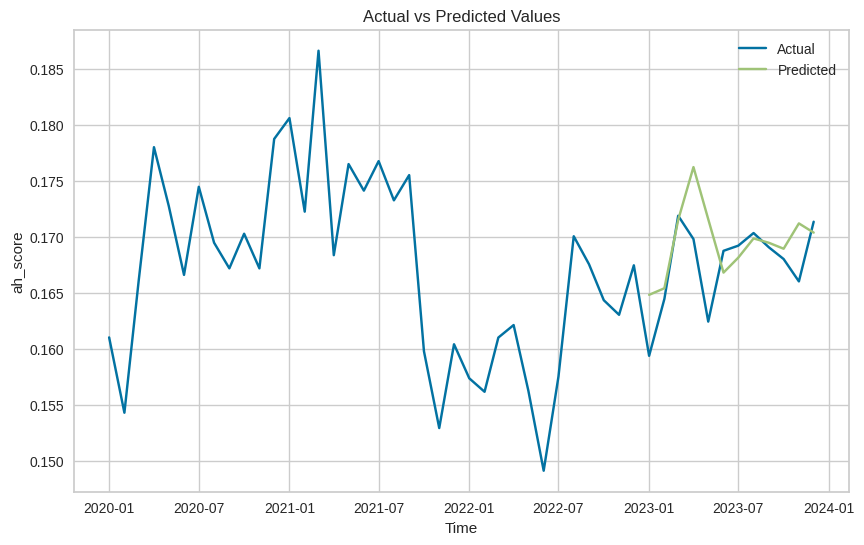

In [ ]:
# Make predictions on test data
start_index = norm_monthly_avg_scores_test.index[0]
end_index = norm_monthly_avg_scores_test.index[-1]
arima_predictions = model_fit.predict(start=start_index, end=end_index)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))

# add markers here to understand what we are trying to predict
plt.plot(combined_monthly_avg_scores.index, combined_monthly_avg_scores, label='Actual')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('ah_score')
plt.legend()
plt.grid(True)
plt.show()


When comparing the actual values in the data set to the predicted values from the ARIMA model, we have found the overall result to be unsatisfactory.  Both models share a similar curve and structure, however, they are not as aligned as we would like.

##### Training Set Predictions


In [ ]:
# Make predictions with training set instead

###Age Class Modeling

####Aggregating Normalized and Standardized AH Score for each age_class

In [ ]:
aggregated_dfs = {}
for age_class, df in filtered_age_class_dfs.items():
    # Group by 'month_begin_date', then calculate the mean 'seg_norm_ah_score'
    norm_aggregated_df = df.groupby('month_begin_date')['seg_norm_ah_score'].mean().reset_index(name='norm_agg_score')
    stan_aggregated_df = df.groupby('month_begin_date')['seg_stan_ah_score'].mean().reset_index(name='stan_agg_score')

    merged_df = pd.merge(norm_aggregated_df, stan_aggregated_df, on='month_begin_date')
    aggregated_dfs[age_class] = merged_df

##SORT BY MONTH_BEGIN_DATE
for age_class, df in aggregated_dfs.items():
    df['month_begin_date'] = pd.to_datetime(df['month_begin_date'])
    df = df.sort_values(by='month_begin_date')
    # Store the sorted DataFrame back in the dictionary
    aggregated_dfs[age_class] = df

del filtered_age_class_dfs

Because the full dataset was not able to completely accurately capture the time series, we repeat the process again with the augmented data sets for each age class.  

#### Augmented Dickey-Fuller (ADF) Test for each age_class

In [ ]:
for age_class, df in aggregated_dfs.items():
  adf_norm_result = adfuller(df['norm_agg_score'])
  print(f"Normalize score ADF test results for age_class: {age_class}")
  print("ADF Statistic:", adf_norm_result[0])
  print("p-value:", adf_norm_result[1])
  print("Critical Values:", adf_norm_result[4])
  print("\n")

Normalize score ADF test results for age_class: Under 25
ADF Statistic: -2.1711927977163326
p-value: 0.21686640978349925
Critical Values: {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}


Normalize score ADF test results for age_class: 25-34
ADF Statistic: -3.7977083415449444
p-value: 0.0029308488748024863
Critical Values: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}


Normalize score ADF test results for age_class: 35-44
ADF Statistic: -3.8730518967281062
p-value: 0.002242368701383189
Critical Values: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}


Normalize score ADF test results for age_class: 45-54
ADF Statistic: -3.484498661057161
p-value: 0.008394241032792526
Critical Values: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}


Normalize score ADF test results for age_class: 55-64
ADF Statistic: -2.87787557840443
p-value: 0.04798192007037336
Cr

Based on the results and using a significance threshold of 0.05, only the 35-44, 45-54, and 55-64 age classes are stationary.  This stationarity means that these the ARIMA model will work on these age classes.  

### ACF and PACF Plots

#### Normalized Score ACF and PACF Plots

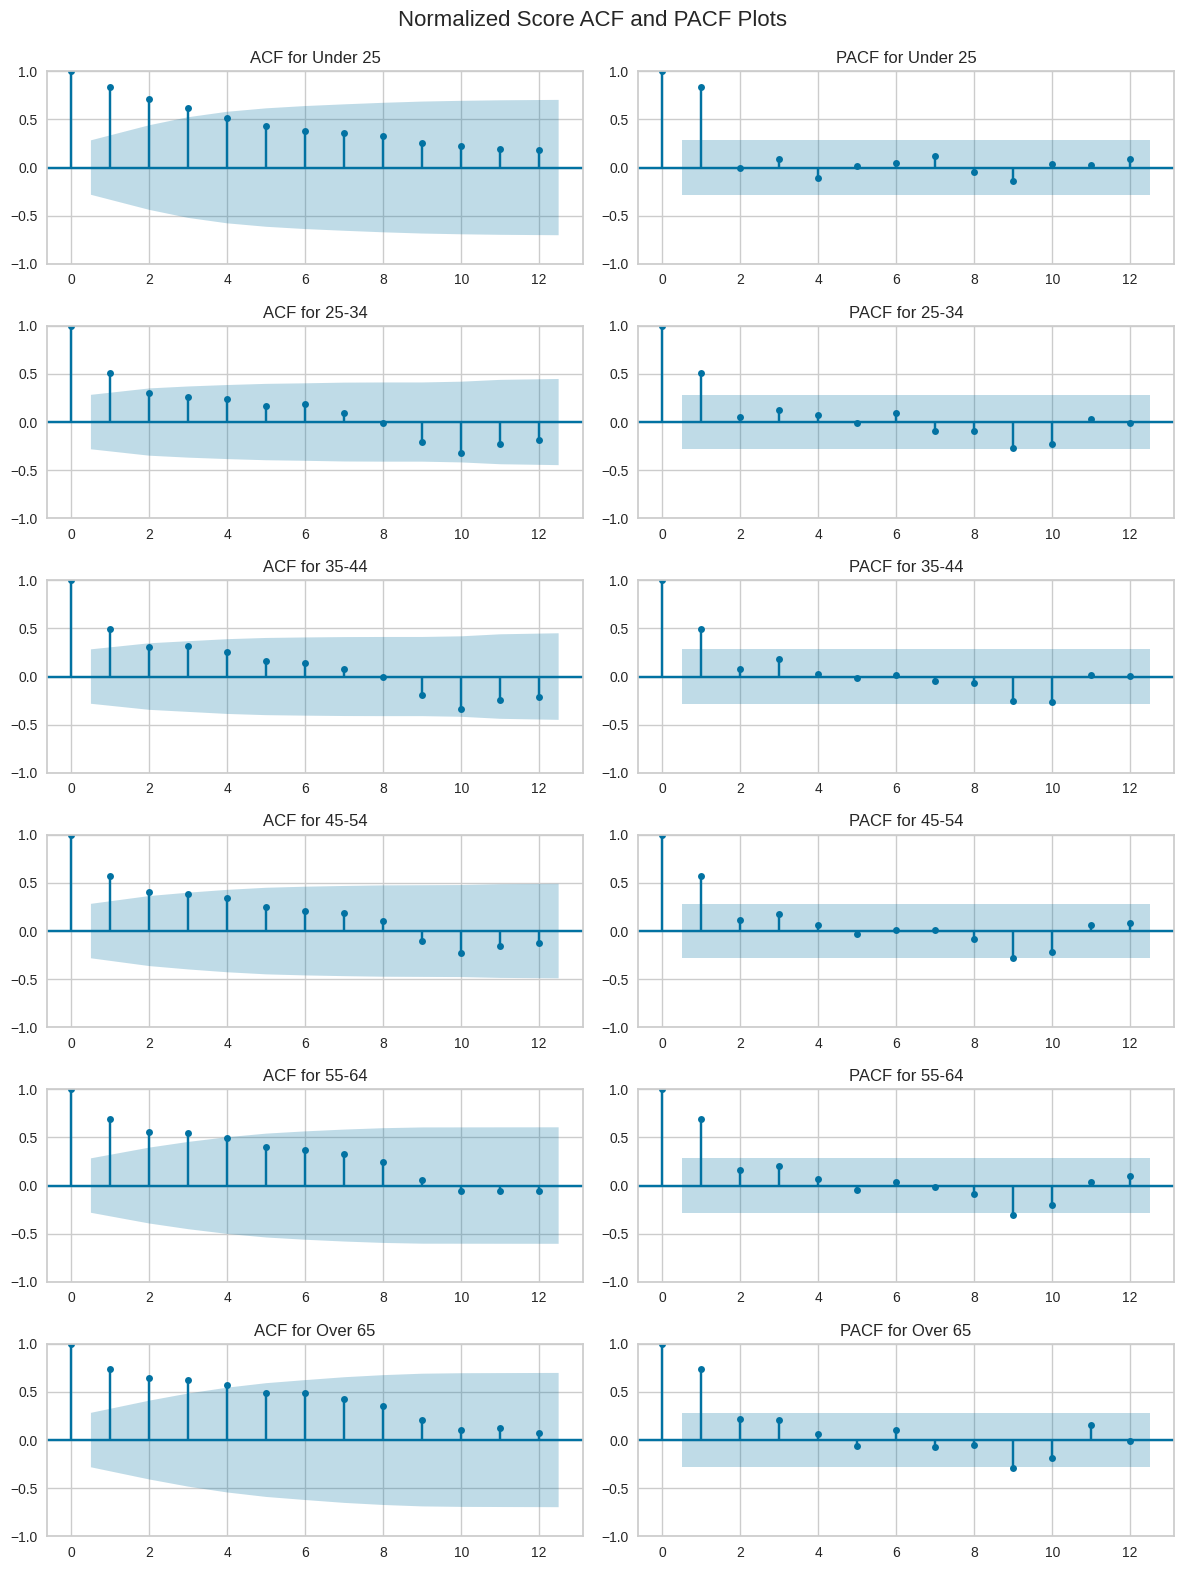

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(12, 16))
fig.suptitle('Normalized Score ACF and PACF Plots', fontsize=16)
for i, (age_class, df) in enumerate(aggregated_dfs.items()):
    plot_acf(df['norm_agg_score'], ax=ax[i, 0], lags=12, title=f'ACF for {age_class}')
    plot_pacf(df['norm_agg_score'], ax=ax[i, 1], lags=12, title=f'PACF for {age_class}')
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

Based on the ACF and PACF plots, we can see that $q \le 1$ and $p \le 1$ is the optimal value.

#### Standardized Score ACF and PACF Plots

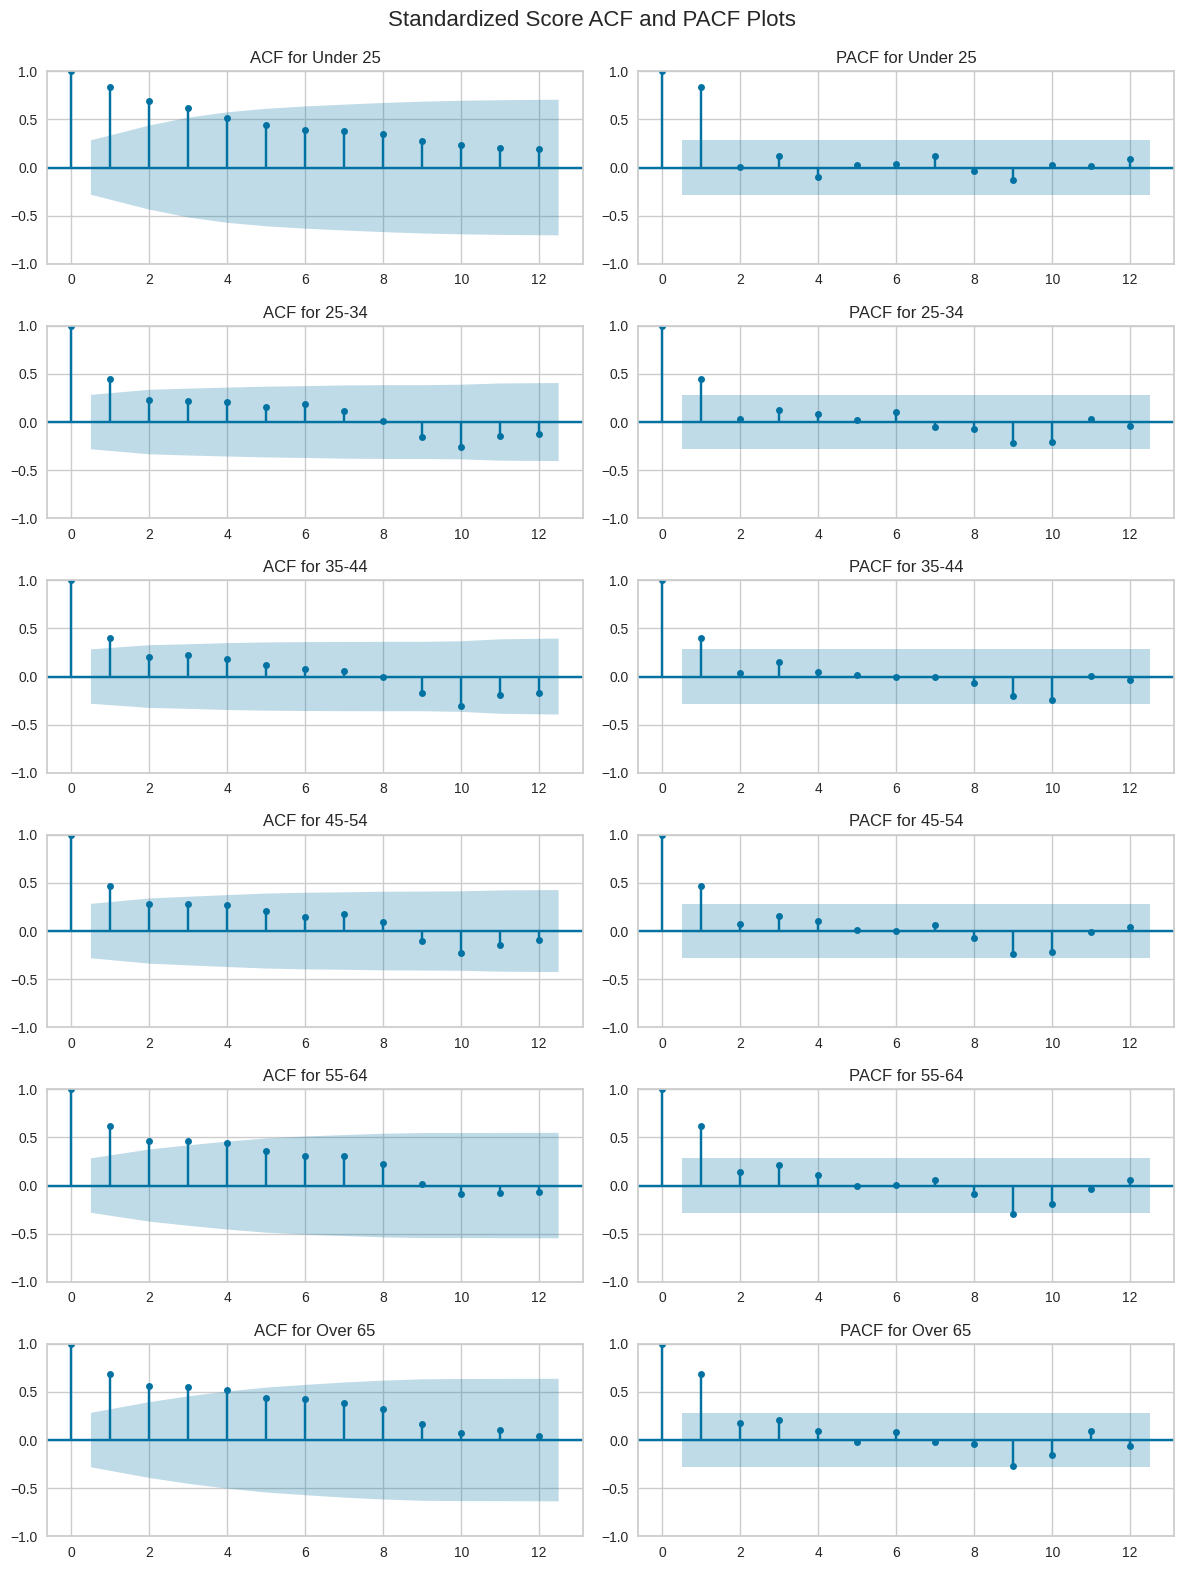

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(12, 16))
fig.suptitle('Standardized Score ACF and PACF Plots', fontsize=16)
for i, (age_class, df) in enumerate(aggregated_dfs.items()):
    plot_acf(df['stan_agg_score'], ax=ax[i, 0], lags=12, title=f'ACF for {age_class}')
    plot_pacf(df['stan_agg_score'], ax=ax[i, 1], lags=12, title=f'PACF for {age_class}')
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

Similar to the ACF and PACF plots of the normalized data set, the plots for the standardized data set give similar results.  The optimal value will be $q \le 1$ and $p \le 1$.  

#### ARIMA Models for Each Age Class Based on Training Data

This code loops through the different age classes and calls the `arima_order_function` to determine the best order parameters and plot the prediction curve.  This prediction curve is then compared to the actual account health score results.  However, in each age group, the prediction curves deviate from the actual results.

Note: this code takes 9 minutes to run.

Optimal ARIMA Order: (9, 0, 3)
Minimum Mean of Absolute Differences: 0.028679094011445878


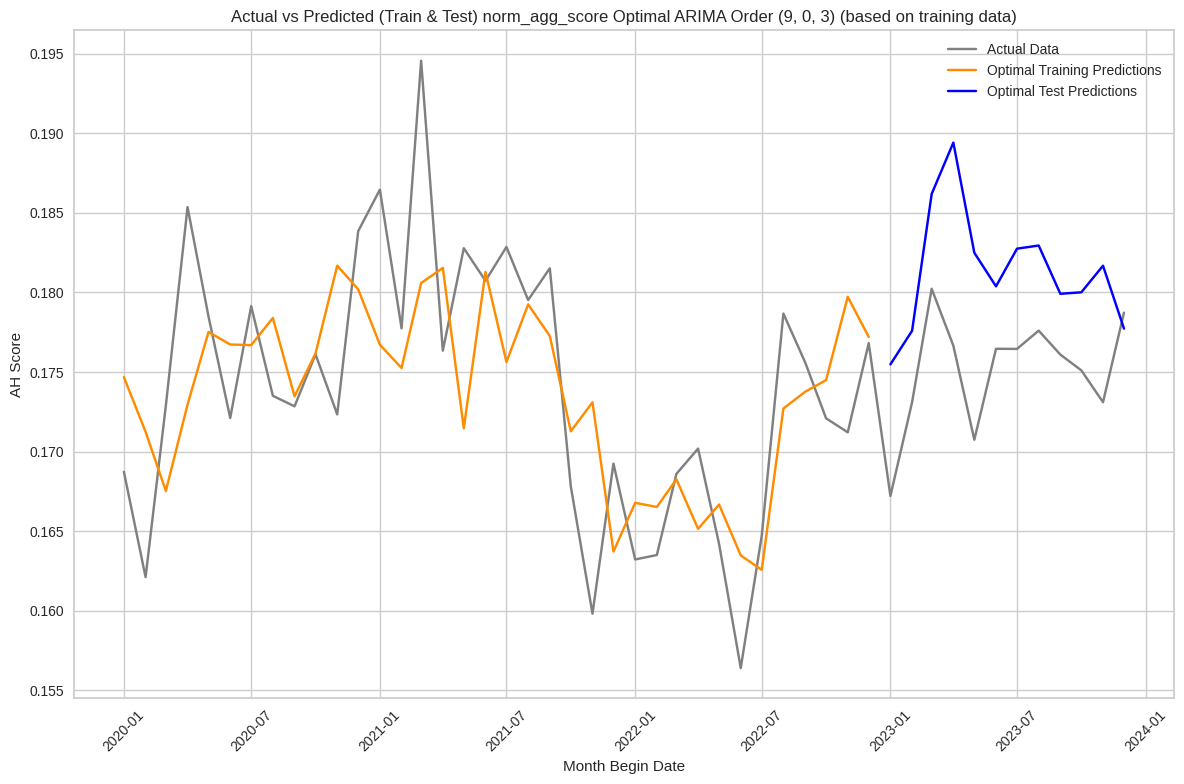

Optimal ARIMA Order: (0, 2, 0)
Minimum Mean of Absolute Differences: -70.20077666997813


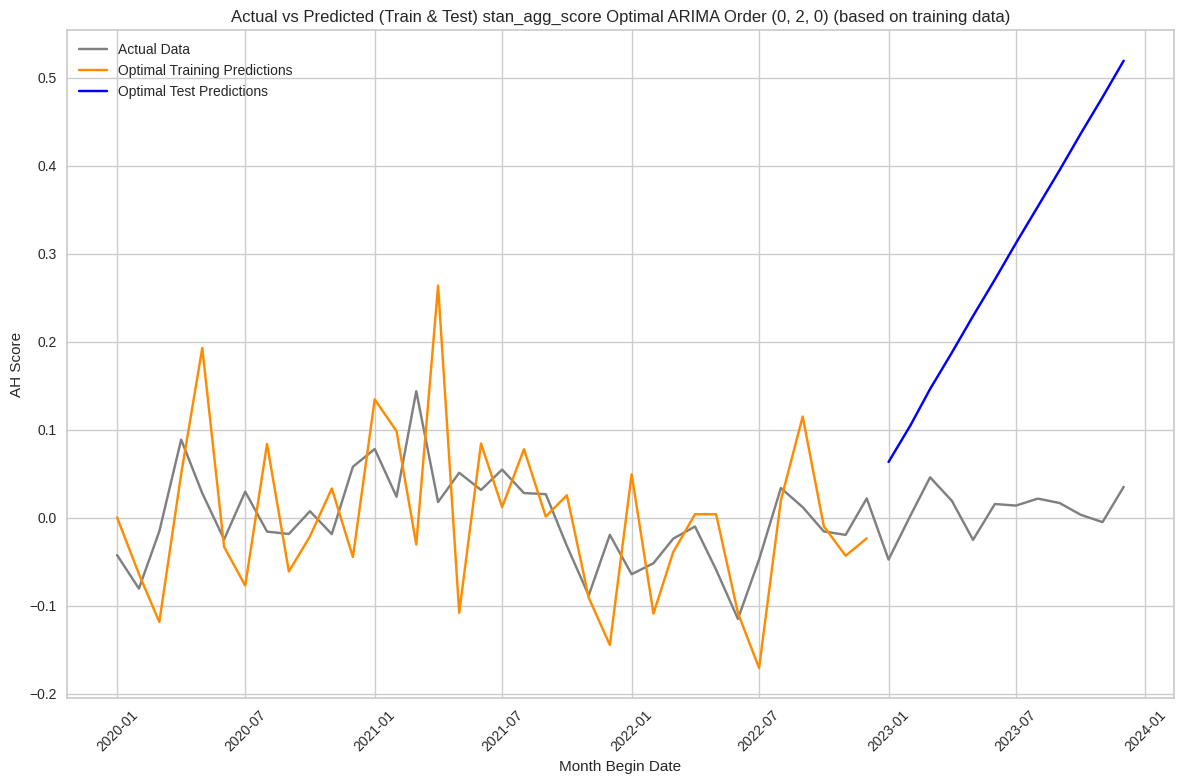

Optimal ARIMA Order: (3, 0, 2)
Minimum Mean of Absolute Differences: 0.02958742202776815


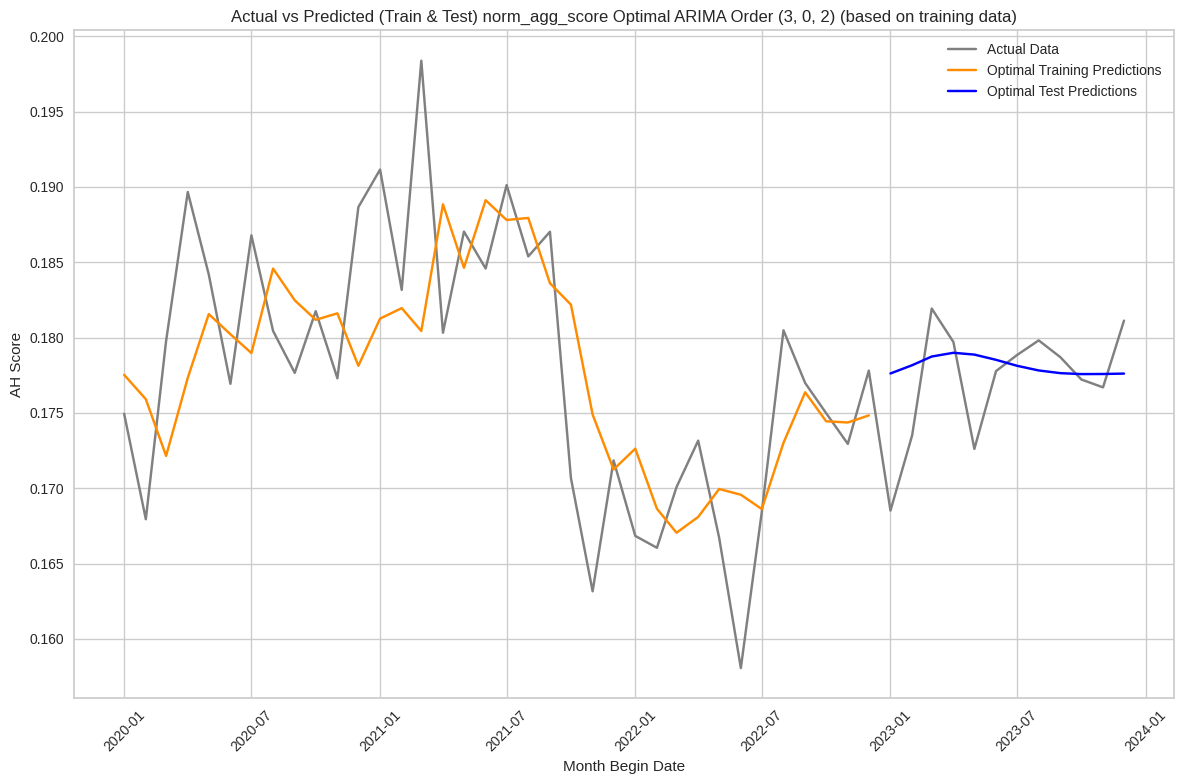

Optimal ARIMA Order: (8, 0, 1)
Minimum Mean of Absolute Differences: 18.12919215883476


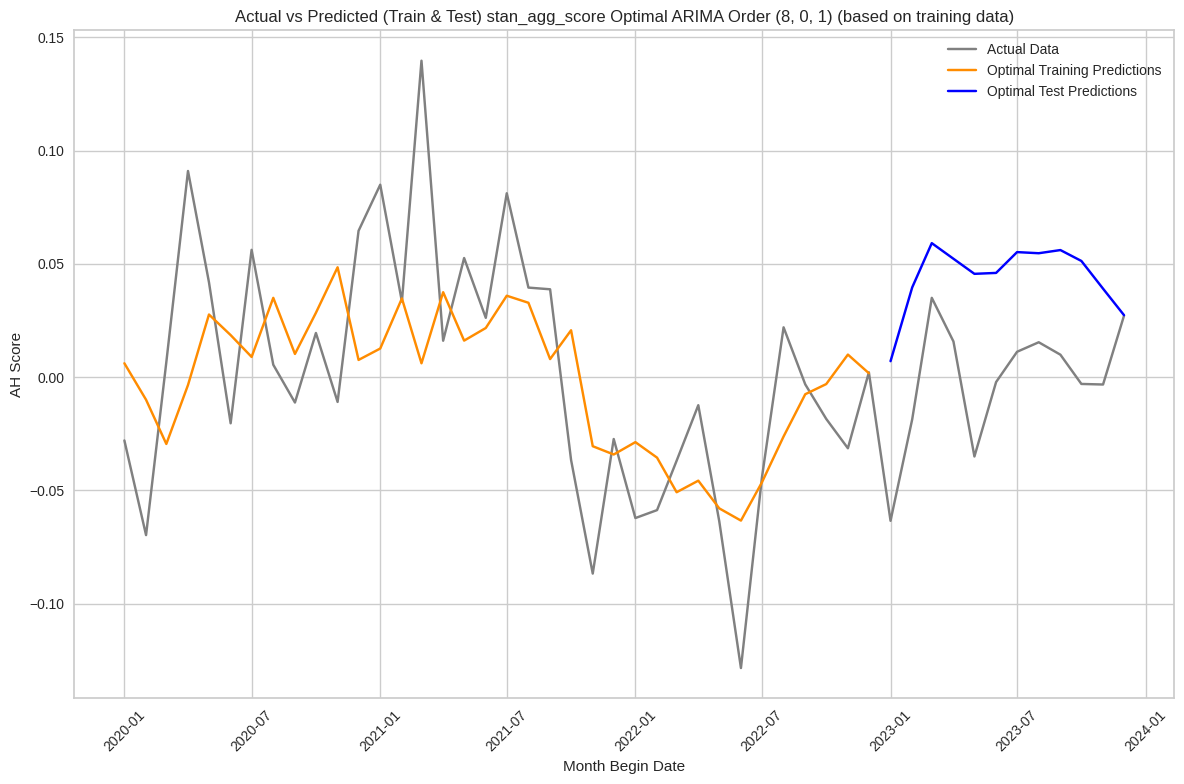

Optimal ARIMA Order: (9, 0, 3)
Minimum Mean of Absolute Differences: 0.02993891228226434


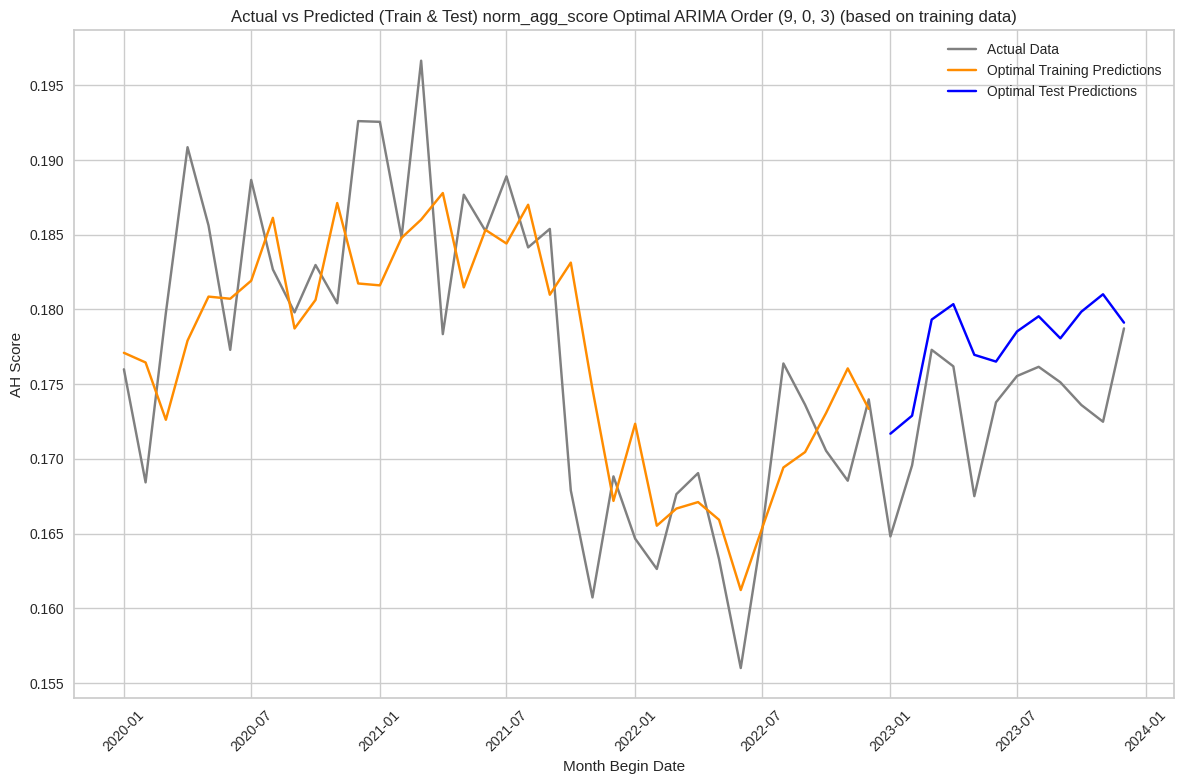

Optimal ARIMA Order: (9, 0, 4)
Minimum Mean of Absolute Differences: 5.823592387761602


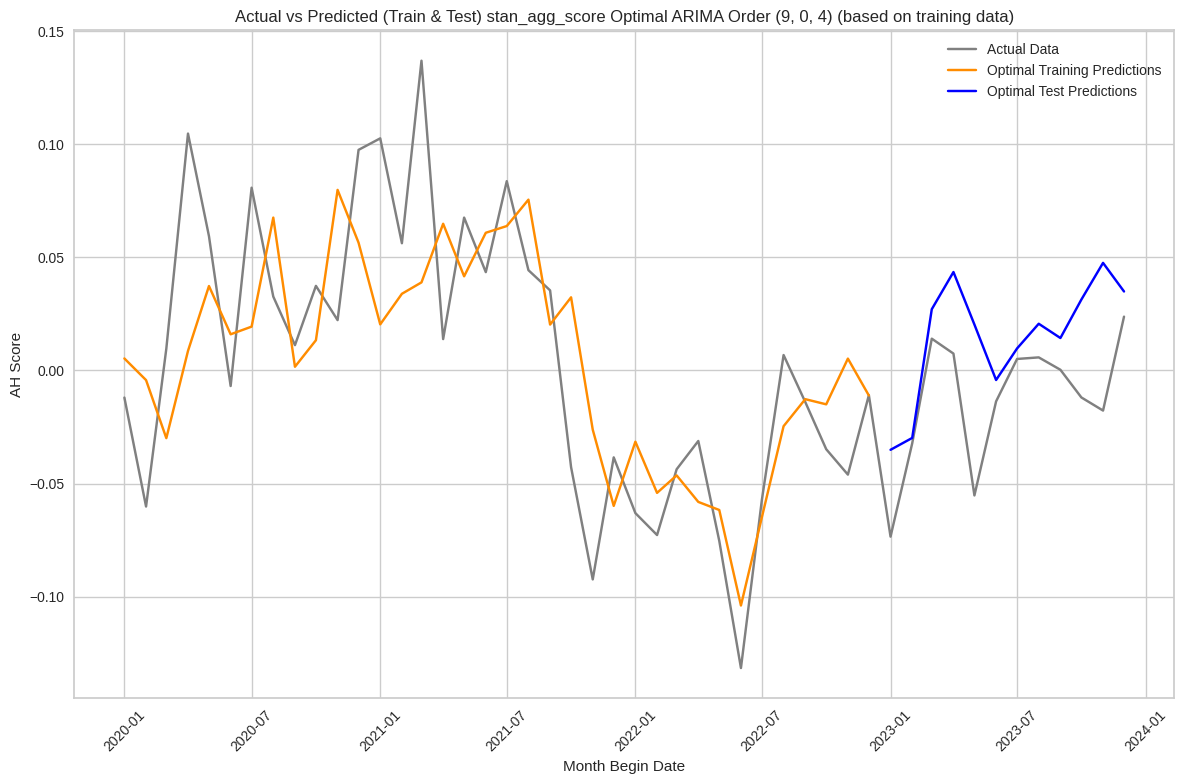

Optimal ARIMA Order: (9, 0, 3)
Minimum Mean of Absolute Differences: 0.03098936397578276


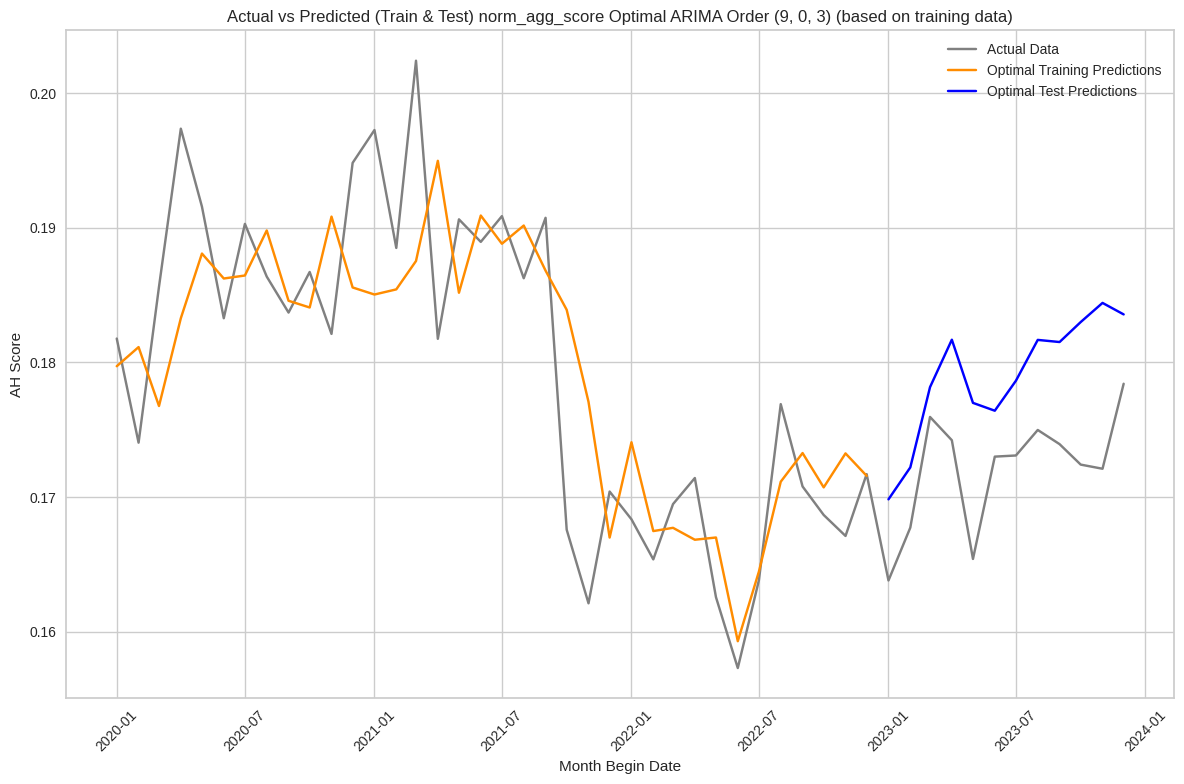

Optimal ARIMA Order: (8, 0, 1)
Minimum Mean of Absolute Differences: 3.0694621834424587


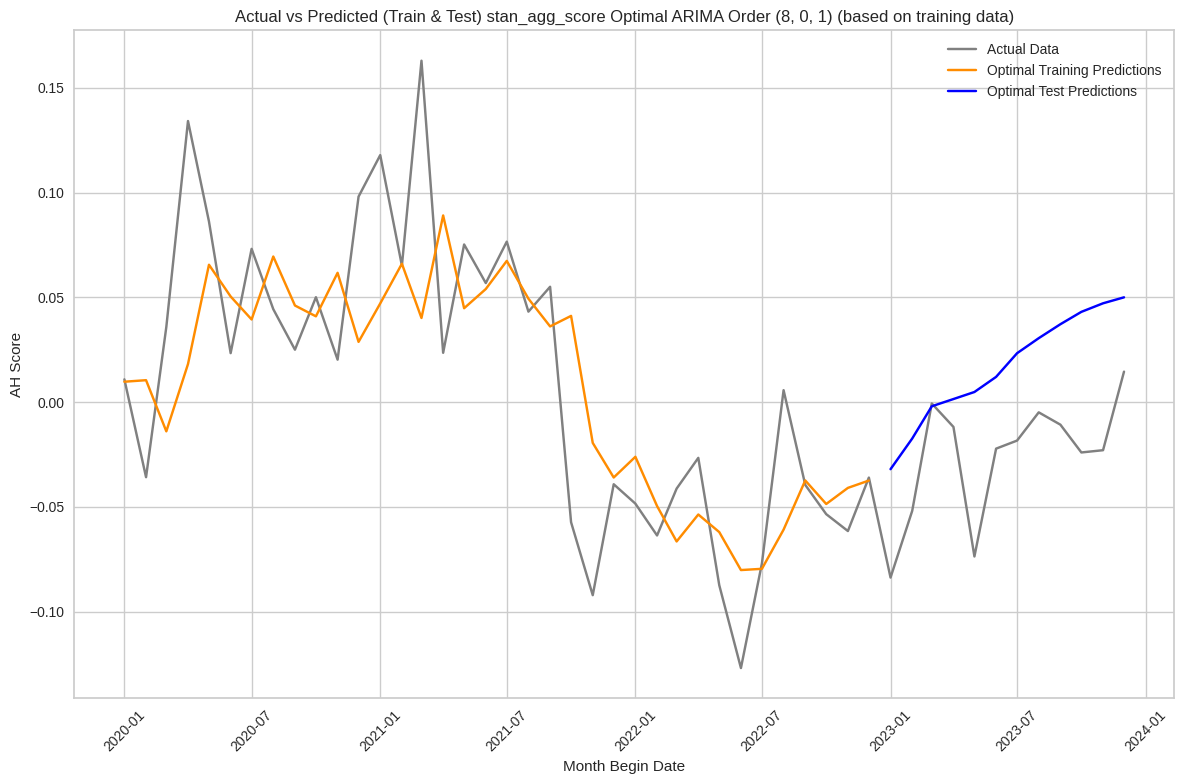

In [ ]:
# Define parameter ranges for ARIMA orders
min_p, min_d, min_q = 0, 0, 0
max_p, max_d, max_q = 10, 3, 5

# Iterate over age groups and score types
for age_group in ['35-44', '45-54', '55-64', 'Over 65']:
    # Iterate over score types
    for score_type in ['norm_agg_score', 'stan_agg_score']:
        # Call arima_order_finder function with specified arguments
        arima_order_finder(aggregated_dfs[age_group], score_type, min_p, min_d, min_q, max_p, max_d, max_q)


For each age class, the optimal ARIMA orders are as follows:

| Age Class and Data Type                  | Optimal Order |
|-----------------------------|----------------------------|
| 35 - 44:  Normalized                   | (9, 0, 3)                    |
| 35 - 44:  Standardized                    | (0, 2, 0)                   |
| 45 - 54:  Normalized                     | (3, 0, 2)                  |
| 45 - 54:  Standardized                    | (8, 0, 1)                   |
| 55 - 64:  Normalized                    | (9, 0, 3)                   |
| 55 - 64:  Standardized                    | (9, 0, 4)                 |
| Over 65:  Normalized                    | (9, 0, 3)                   |
| Over 65:  Standardized                    | (8, 0, 1)                 |



Based on the results shown, these models do not accurately capture the oscillations in account health score.  

This is especially prevalent in the standardized account health score prediction for 35-44.  While the actual values range between -0.05 and 0.05, the prediction curve is a line ranging between 0.07 and 0.55.  

The prediction curves for both the normalized and standardized scores for 55-64 may look more similar to the actual values, but the final predictions do not capture what is really happening.  In both curves, the model predicts the account health score will decrease between December 2023 and January 2024, where the actual values increase.  This discrepancy could lead to inaccurate predictions.  

#### Cheated Version: Using Testing Data to Find Optimal Orders

##### Finding Orders: Comparison Between Absolute Value Difference and Self-Adjusting the Orders




NOTE: This code takes 4 minutes to run

When determining the order parameters, one method is to use the absolute value of the difference between the predicted value and the actual value.  However, while it may reduce the residuals, it creates a model that does not fully capture the trend.

To illustrate this, the 35-44 age class is used.  One method iterates through all possible order combinations and chooses the model with the lowest number of residuals, and the other method uses the order adjusted manually.  Although these models visually capture the trends better, the way we got to the ARIMA orders was by "cheating" and manually testing different orders until the curve suited our liking.

We wanted to focus on choosing the model that best represents trends over the model with the lowest error so it can be more useful in making predictions and predicting account health scores in the future.  This model would be more useful for the credit union, even though it is not as mathematically sound.  

In [ ]:
# Define parameter ranges
p_values = range(0, 13)  # p ranges from 0 to 12
d_values = range(0, 4)   # d ranges from 0 to 3
q_values = range(0, 6)   # q ranges from 0 to 5

# Define DataFrame
df = aggregated_dfs['35-44']
df['month_begin_date'] = pd.to_datetime(df['month_begin_date'])

# Split into training and test sets
train = df[df['month_begin_date'] <= '2022-12-01']
test = df[df['month_begin_date'] >= '2023-01-01']

# Initialize variables for optimal order and minimum error metric
optimal_order = None
min_error = float('inf')

# Iterate over all parameter combinations
for p, d, q in itertools.product(p_values, d_values, q_values):
    order = (p, d, q)

    # Fit ARIMA model
    model = ARIMA(train['norm_agg_score'], order=order)
    model_fit = model.fit()

    # Make predictions for the test period
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

    # Calculate sum of absolute differences
    error = np.sum(np.abs(predictions - test['norm_agg_score']))

    # Check if current error is lower than minimum error
    if error < min_error:
        min_error = error
        optimal_order = order

# Print the optimal ARIMA order and corresponding error metric
print(f"Optimal ARIMA Order: {optimal_order}")
print(f"Minimum Sum of Absolute Differences: {min_error}")

Optimal ARIMA Order: (3, 2, 0)
Minimum Sum of Absolute Differences: 0.02801950390003413


##### ARIMA Model for Age Class 35-44 with order (3, 2, 0)

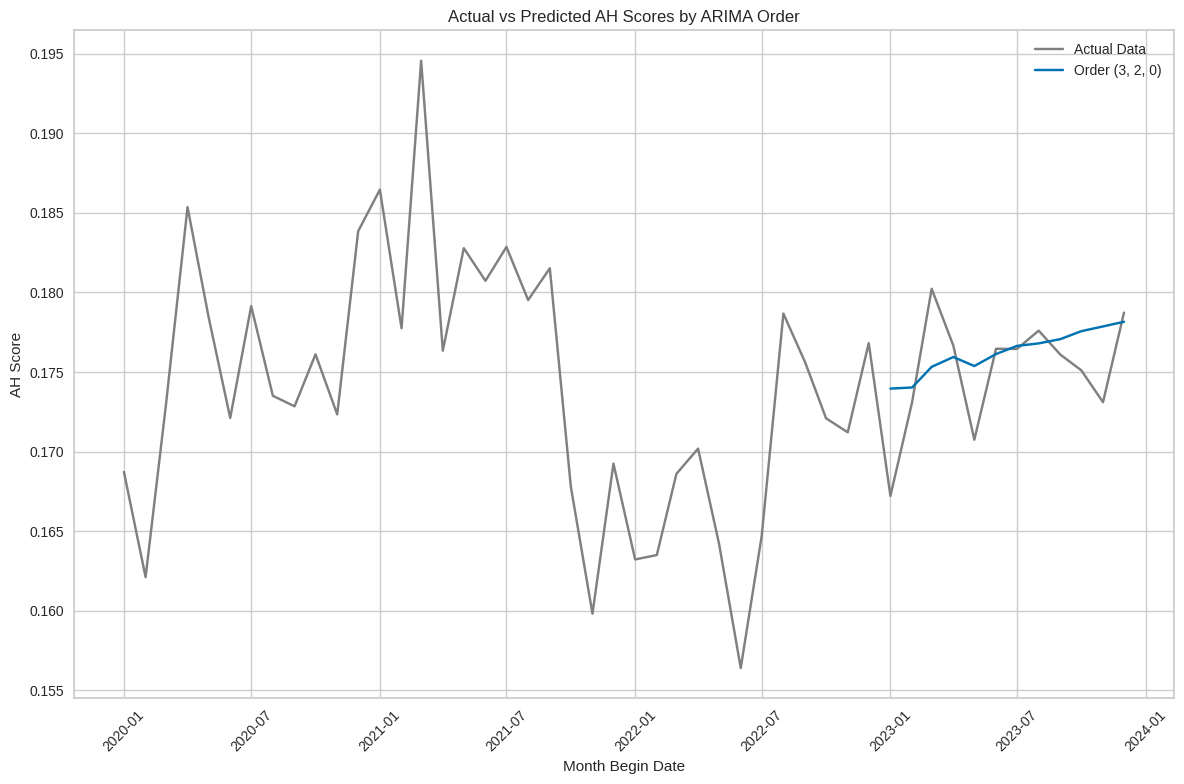

In [ ]:
# Define the ARIMA order
orders = [
    (3, 2, 0)
]

# Extract the DataFrame
df = aggregated_dfs['35-44']

# Ensure 'month_begin_date' is in datetime format
df['month_begin_date'] = pd.to_datetime(df['month_begin_date'])

# Split into training and test sets based on 'month_begin_date'
train = df[df['month_begin_date'] <= '2022-12-01']
test = df[df['month_begin_date'] >= '2023-01-01']

colors = sns.color_palette("colorblind", n_colors=len(orders))
plt.figure(figsize=(12, 8))
plt.plot(df['month_begin_date'], df['norm_agg_score'], label='Actual Data', color='gray')

# Iterate through each order and plot the results
for i, order in enumerate(orders):
    # Fit the ARIMA model on the training set
    model = ARIMA(train['norm_agg_score'], order=order)
    model_fit = model.fit()

    # Make predictions for the test period
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

    # Create DataFrame for predictions
    prediction_index = pd.date_range(start='2023-01-01', periods=len(test), freq='MS')
    pred_df = pd.DataFrame({"month_begin_date": prediction_index, "predicted_ah_score": predictions})

    # Add plot for predicted test data
    plt.plot(pred_df['month_begin_date'], pred_df['predicted_ah_score'], label=f'Order {order}', color=colors[i])

plt.title('Actual vs Predicted AH Scores by ARIMA Order')
plt.xlabel('Month Begin Date')
plt.ylabel('AH Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

While this model has the lowest error, it does not accurately capture the trend in account health.  When looking at the actual vs. predicted values, the area between the curve is close to 0.  However, this is because there are values above the line and below which cancel out.  

##### ARIMA Model for Age Class 35-44 with order (8, 1, 2)

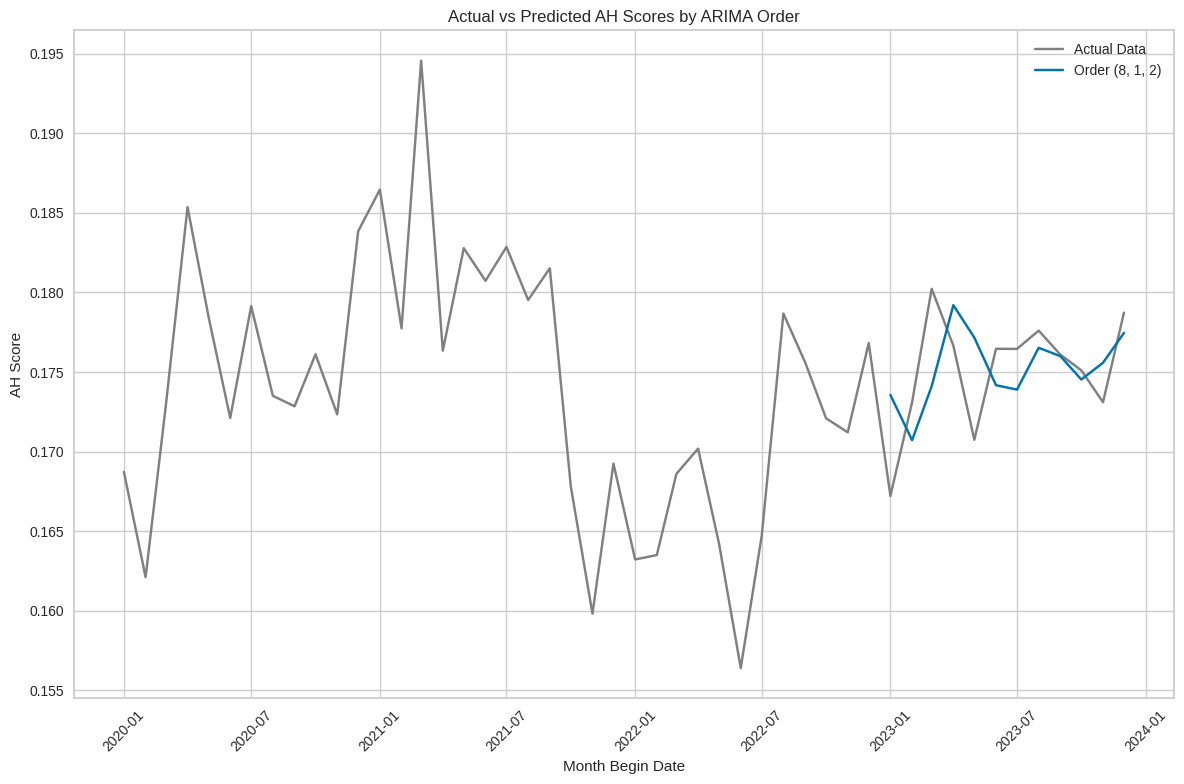

In [ ]:
# Define the ARIMA order
orders = [
    (8, 1, 2)
]

# Extract the DataFrame
df = aggregated_dfs['35-44']

# Ensure 'month_begin_date' is in datetime format
df['month_begin_date'] = pd.to_datetime(df['month_begin_date'])

# Split into training and test sets based on 'month_begin_date'
train = df[df['month_begin_date'] <= '2022-12-01']
test = df[df['month_begin_date'] >= '2023-01-01']

colors = sns.color_palette("colorblind", n_colors=len(orders))
plt.figure(figsize=(12, 8))
plt.plot(df['month_begin_date'], df['norm_agg_score'], label='Actual Data', color='gray')

# Iterate through each order and plot the results
for i, order in enumerate(orders):
    # Fit the ARIMA model on the training set
    model = ARIMA(train['norm_agg_score'], order=order)
    model_fit = model.fit()

    # Make predictions for the test period
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

    # Create DataFrame for predictions
    prediction_index = pd.date_range(start='2023-01-01', periods=len(test), freq='MS')
    pred_df = pd.DataFrame({"month_begin_date": prediction_index, "predicted_ah_score": predictions})

    # Add plot for predicted test data
    plt.plot(pred_df['month_begin_date'], pred_df['predicted_ah_score'], label=f'Order {order}', color=colors[i])

plt.title('Actual vs Predicted AH Scores by ARIMA Order')
plt.xlabel('Month Begin Date')
plt.ylabel('AH Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This code runs an ARIMA model with the Standardized data set for the 35-44 age class and the parameters (8, 1, 2).

In this model, the variablity in account health is better captured than the previous model. This can be seen in February 2023 when both the testing data and the model increase and then decrease. Additionally, this can be seen for November 2023 when both the testing data and model imcrease and then decrease. However, it is not able to capture the dramatic account health score increase in December 2023.

###### ARIMA Model for Normalized and Standardized Score for Different Age Groups

Since we have proved in the last section, "human adjusting orders" method is a best way to predict the trend, thus we manipulate orders in this section regarding each age group.

Score Type: norm_agg_score
Processing Age Group: 35-44, Order: (8, 1, 2)


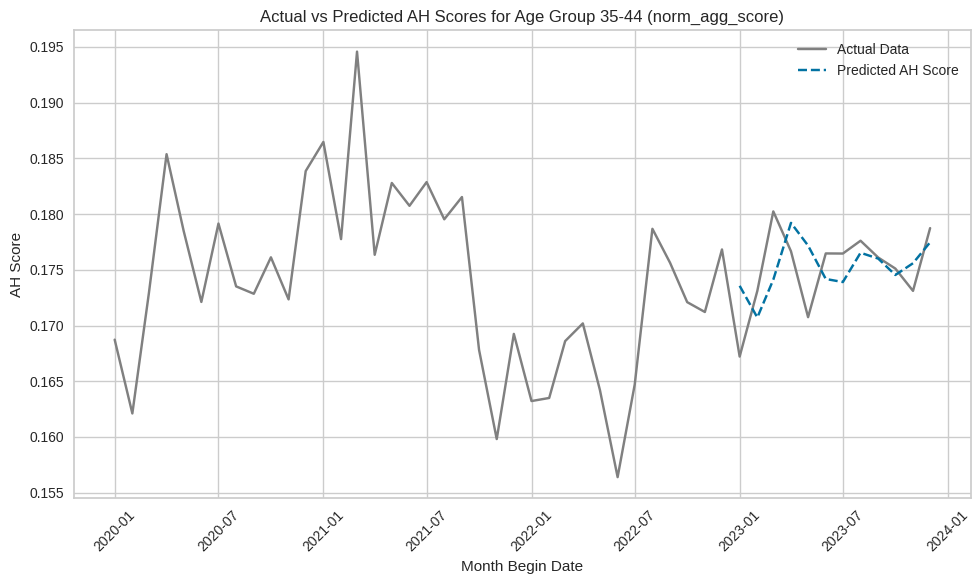

Processing Age Group: 45-54, Order: (8, 1, 2)


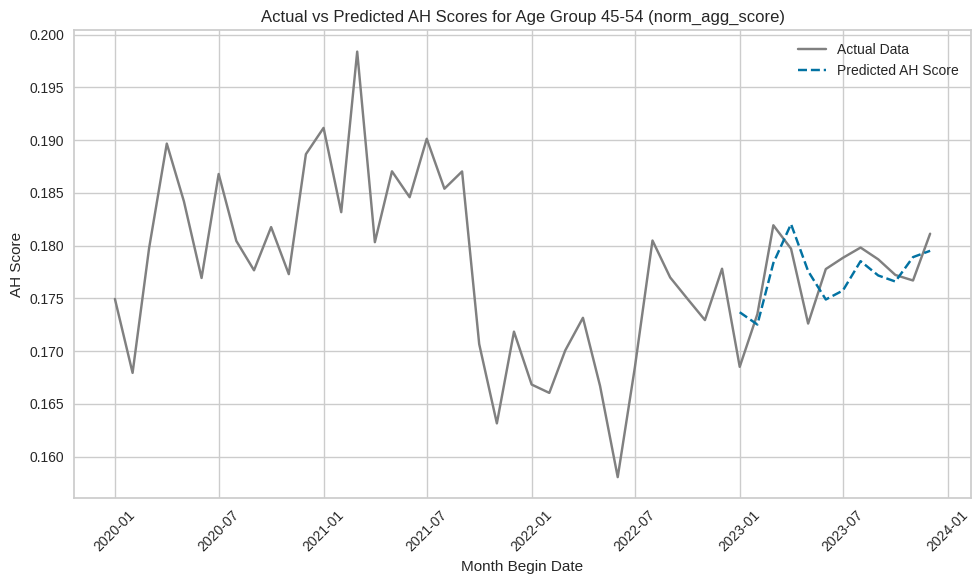

Processing Age Group: 55-64, Order: (8, 1, 2)


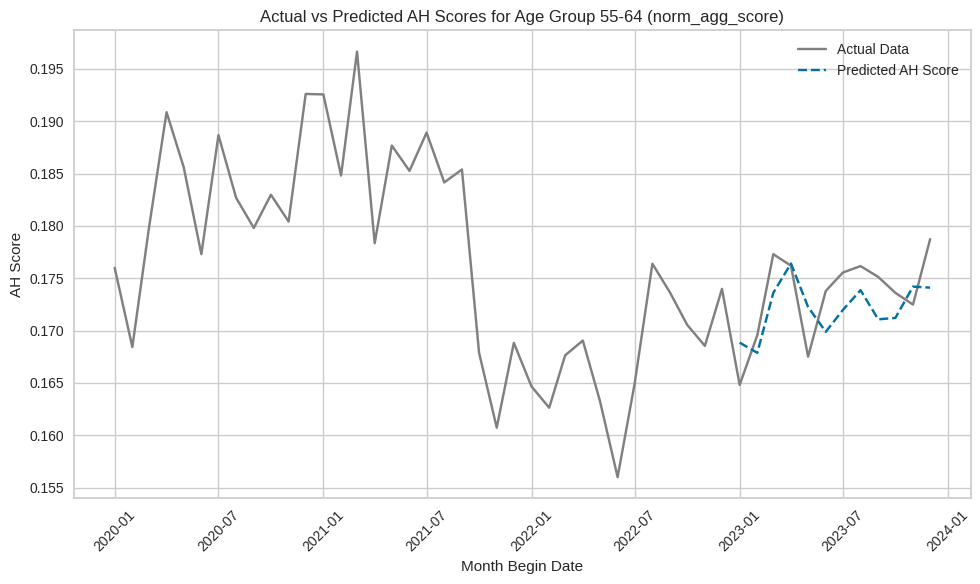

Processing Age Group: Over 65, Order: (8, 1, 2)


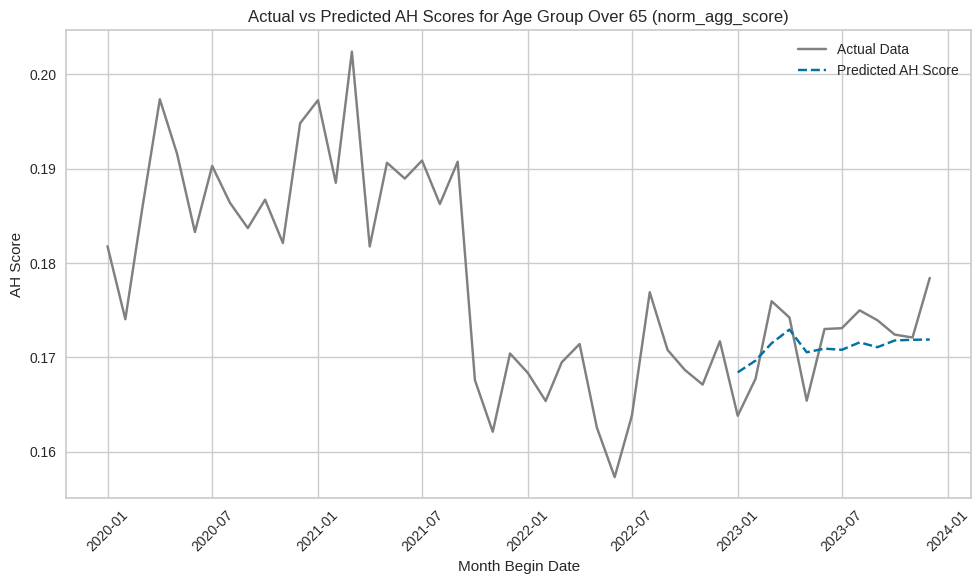

Score Type: stan_agg_score
Processing Age Group: 35-44, Order: (10, 2, 3)


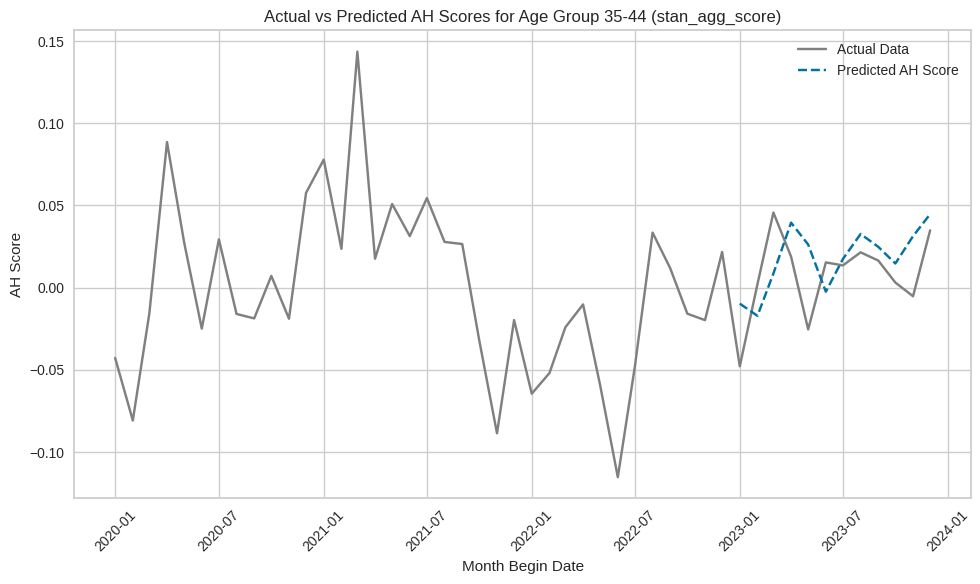

Processing Age Group: 45-54, Order: (10, 2, 3)


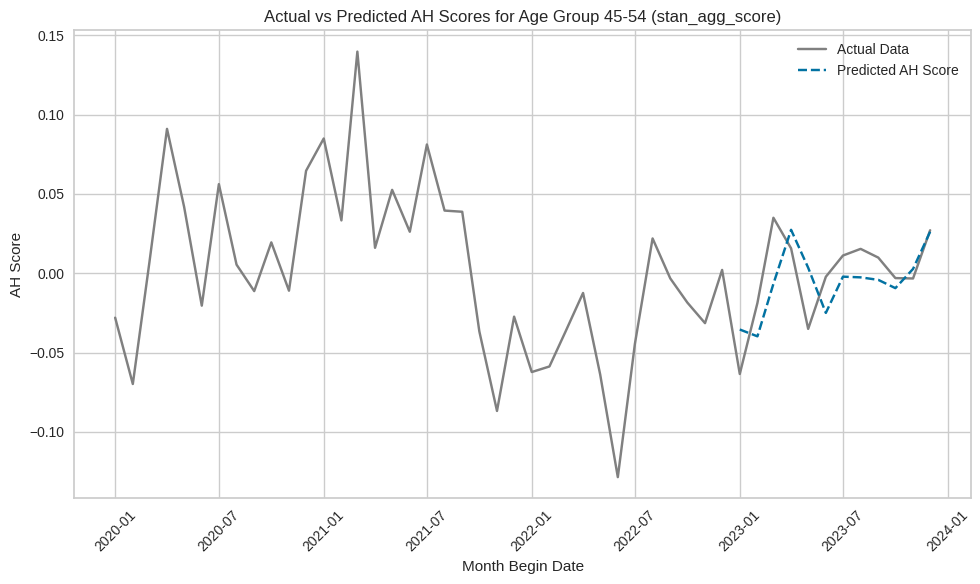

Processing Age Group: 55-64, Order: (10, 2, 3)


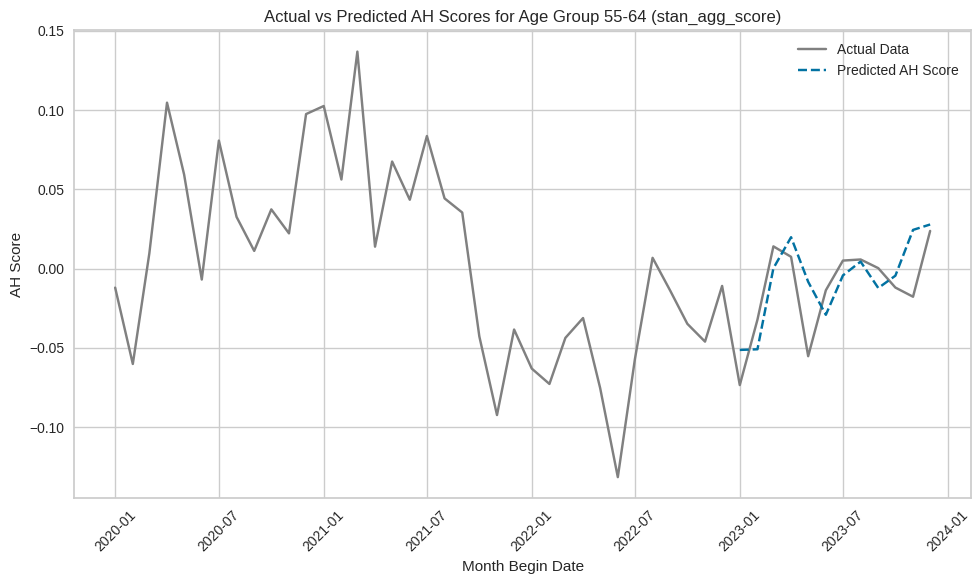

Processing Age Group: Over 65, Order: (10, 2, 3)


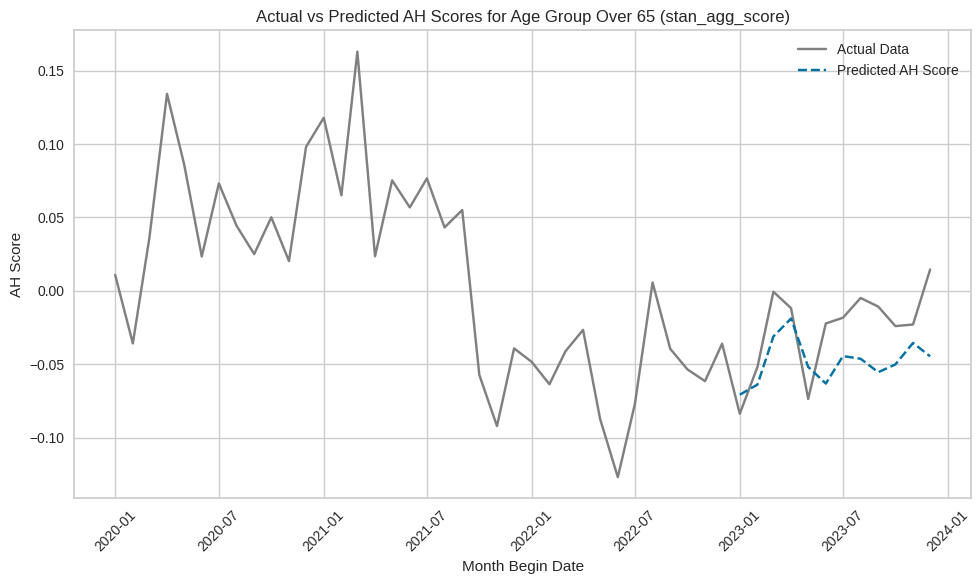

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Define the orders for each age group and score type
orders = {
    'norm_agg_score': {
        '35-44': (8, 1, 2),
        '45-54': (8, 1, 2),
        '55-64': (8, 1, 2),
        'Over 65': (8, 1, 2)
    },
    'stan_agg_score': {
        '35-44': (10, 2, 3),
        '45-54': (10, 2, 3),
        '55-64': (10, 2, 3),
        'Over 65': (10, 2, 3)
    }
}

# Iterate over each score type
for score_type, age_groups in orders.items():
    print(f"Score Type: {score_type}")
    for age_group, order in age_groups.items():
        print(f"Processing Age Group: {age_group}, Order: {order}")

        # Extract the DataFrame for the specific age group and score type
        df = aggregated_dfs[age_group]

        # Ensure 'month_begin_date' is in datetime format
        df['month_begin_date'] = pd.to_datetime(df['month_begin_date'])

        # Split into training and test sets based on 'month_begin_date'
        train = df[df['month_begin_date'] <= '2022-12-01']
        test = df[df['month_begin_date'] >= '2023-01-01']

        # Fit the ARIMA model on the training set
        model = ARIMA(train[score_type], order=order)
        model_fit = model.fit()

        # Make predictions for the test period
        predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

        # Create DataFrame for predictions
        prediction_index = pd.date_range(start='2023-01-01', periods=len(test), freq='MS')
        pred_df = pd.DataFrame({"month_begin_date": prediction_index, "predicted_ah_score": predictions})

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(df['month_begin_date'], df[score_type], label='Actual Data', color='gray')
        plt.plot(pred_df['month_begin_date'], pred_df['predicted_ah_score'], label='Predicted AH Score', linestyle='--')
        plt.title(f'Actual vs Predicted AH Scores for Age Group {age_group} ({score_type})')
        plt.xlabel('Month Begin Date')
        plt.ylabel('AH Score')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


From this loop, we can find something special.  For normalized score, the optimal order for each age groups is (8,1,2), and for standardized score, the optimal order for each age groups is (10,2,3). The reason is from the graph in previous section, we show that except for age group Under 25, all other groups have similar account health score trends. Although this result shows we can not predict future trend based on different age groups, but it proves our model is correct. We can use this optimal order to predict the trend regarding entire population, no matter use normalization or standardization. We can provide this optimal order to credit union team and help them capture the deviaitons of customers' engagement better.

##Conclusion
> **What are you personally taking away from this project?**

This project appealed to us because some of us already had experience working with data analytics and predicting member engagement, and some of us are wanting to go into this field.  Time series is a topic that none of us had any experience with prior, so this project taught us a lot about not only what it is, but the different parts that go into it (seasonality, data transformations, why it cannot be applied to every situation).  This project also taught us how to play to our individual advantages and ensure everything got done.

> **What do you want the reader to take away from this project?**

We hope that the reader has a better understanding of data science methodologies such as data scaling and visualization, and time series.  With our analysis, we hope the sponsor is able to understand how different age groups’ account health score changes over time to better market to them.  During our testing phases, we also tried segmenting the data by median household income.  We believe that this project can be expanded to include segmenting the data by other demographic means to better cater the credit union experience to its members.  We hope that future students are able to build on this work with further explorations in data analysis.  

> **Be honest about what conclusions are really supported**

In this project, we wanted to use time series to track the oscillations in account health score for different age groups.  When using the training data to find the optimal ARIMA orders, the result is not good and lead to models that did not accurately predict the testing data.  

However, when we "cheated" the ARIMA orders by focusing on the testing set, it is possible to find optimal orders for the different age groups.  For the normalized account health score, the optimal order is (8, 1, 2) and for the standardized account health score, the optimal order is (10, 2, 3).  Although these orders provide more desirable results, they were "circumstantial" and not based on our training data.  

> **Potential Future Work**

Although we found an optimal order for the ARIMA model of the testing data, we could not find a way to find the optimal orders based on the training data.  Future work would apply better methods to transform the data to better apply the time series.  


> **Feedback From Sponsor**

After sharing results with our sponsor, she, and the rest of the Credit Union, were very excited about our results.

However, they still wanted to see how the results of our project can be applied to making predictions.  They noted how different members may deviate from the more general trends we discoverered.  They would love to see a model that is more tailored to a specific member.  This would include providing the appropriate ARIMA model parameters to their age group and data set and determining how overfitting or underfitting could skew their results.  

## References

“4.1 Seasonal ARIMA Models | STAT 510.” PennState: Statistics Online Courses, online.stat.psu.edu/stat510/lesson/4/4.1.

Brockwell, Peter J, and Richard A Davis. Introduction to Time Series and Forecasting. Springer Verlag, 2013.

Danao, Monique. “Customer Engagement in 2023: The Ultimate Guide – Forbes Advisor.” Www.forbes.com, 12 Sept. 2023, www.forbes.com/advisor/business/customer-engagement/.

Majaski, Christina. “What Is a Seasonal Adjustment?” Investopedia, 2022, www.investopedia.com/terms/s/seasonal-adjustment.asp.

Nau, Robert. Lecture Notes on Forecasting Introduction to ARIMA Models. 2014.

Noxon, Don. “Learn SQL Basics for Data Science Specialization.” Coursera, UC Davis.

Peixeiro, Marco. “Time Series Model: A Guide | Built In.” Builtin.com, 1 Aug. 2023, builtin.com/data-science/time-series-model.

PHILLIPS, PETER C. B., and PIERRE PERRON. “Testing for a Unit Root in Time Series Regression.” Biometrika, vol. 75, no. 2, 1988, pp. 335–346, https://doi.org/10.1093/biomet/75.2.335. Accessed 1 Oct. 2019.

Zhang, Mingda. Time Series: Autoregressive Models AR, MA, ARMA, ARIMA Overview 1 Introduction of Time Series Categories and Terminologies White Noise and Random Walk Time Series Analysis. 2018.